In [51]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import psycopg2
from IPython.core.interactiveshell import InteractiveShell
import subprocess
pd.options.display.max_rows = 20
InteractiveShell.ast_node_interactivity = "all"
plt.style.use('dark_background')

#    The data collected for this project from the United States Department of Health and Human Services is available at https://ocrportal.hhs.gov/ocr/breach/breach_report.jsf and is further parsed in the json file included in this repository.
#     Based on the data made available by HHS, this analysis aims to answer: what predicts massive medical data breach? Which vectors of the original HHS data set predict data breaches with orders of magnitude above the median order of magnitude of all data breaches in the set?
#   The impetus for this project is to examine a data set that's not gotten tremendous attention, a data set that requires more than a quick command line curl or click to prepare for analysis, and to give others interested in integrating this data into other projects some code, ideas, and hopefully a basis for any helpful application of this data. No modelling of the sort necessary for a web app is provided in the project right now. Notwithstanding this, the R files in this repository automate table creation, table update, and are compatible with systemd, cron and hopefully other task schedulers. Focus on such data at the intersection of healthcare, cybersecurity, privacy, personal security as these from HHS is of chief importance to everyone and feedback, pull requests comments, ideas, emails, questions, tips, etc. are welcomed.

## there's also a json file with the data drawn from the database to allow for reproducing all code without setting up a database 

In [52]:
def getZippedConfigs(pg_keys = None, env_vars = None) -> zip: 
    """ generates database access configuration params in zipped 
    format 

   Parameters 
   ----------
   pg_keys: iterable 
       psycopg2 keywords needed to connect to a postgres database 
   env_vars: iterable
       sequence of environment variables whose values to retrieve 
       from shell 

   Returns 
   -------
   zip 
       zip object, pg_keys and retrieved environment var lists zipped """

    env_vars = ['pghost', 'dbname', 'dbuser', 'pgpw', 'pgport']
    pg_keys = ['host', 'database', 'user', 'password', 'port']
    get_env_var = lambda name: subprocess.getoutput('echo $' + name.upper())
    return zip(pg_keys, list(map(get_env_var, env_vars)))


In [53]:
def getData(configs = None, query = 'SELECT * FROM data_breach')-> list:
    """queries database using configs and query, 
        returns list of all fetched tuples / rows

   Parameters 
   ----------
   configs: dictionary or zip of conformable iterables
       psycopg2 mapping needed to connect to a postgres database 
   query: str
       a SQL query in string form  

   Returns 
   -------
   list 
       list of tuples where each tuple is a retrieved row """ 

    if type(configs) == zip:
        configs = dict(configs)
    try:
        conn = psycopg2.connect(**configs)
        cursor = conn.cursor()
        cursor.execute(query)
        data = cursor.fetchall()
        cursor.close()
        conn.close()
    except: 
        raise Exception("Rows not fetched")
    finally: 
        if conn:
            conn.close()
    return data

## fetch data from database and save the dataframe as a json file for anyone to verify results of analysis  

In [54]:
col_names_query =  """SELECT column_name
                FROM information_schema.columns 
                WHERE (table_schema, table_name) = ('public', 'data_breach')
                ORDER BY ordinal_position;"""

col_names = getData(query = col_names_query, configs = getZippedConfigs())
col_names
data = pd.DataFrame(getData(getZippedConfigs()), 
            columns = list(map(lambda tup: tup[0], col_names)))
data.individuals_affected = data.individuals_affected.astype(float)
data.web_description = data.web_description.astype('str')
data.breach_submission_date = pd.to_datetime(data.breach_submission_date)
outf = "".join(subprocess.getoutput("date").split())
outf = outf.replace(":", "_") + ".json"
data.to_json(outf)
data.sample(10)
data.web_description.isna().sum()

[('breach_id',),
 ('name_of_covered_entity',),
 ('state',),
 ('covered_entity_type',),
 ('individuals_affected',),
 ('breach_submission_date',),
 ('type_of_breach',),
 ('location_of_breached_information',),
 ('web_description',),
 ('business_associate_present',),
 ('archive',),
 ('lobi_network_server',),
 ('lobi_unknown',),
 ('lobi_email',),
 ('lobi_desktop_computer',),
 ('lobi_laptop',),
 ('lobi_other_portable_electronic_device',),
 ('lobi_electronic_medical_record',),
 ('lobi_paper',),
 ('tob_theft',),
 ('tob_loss',),
 ('tob_unknown',),
 ('tob_improper_disposal',),
 ('tob_hacking',),
 ('tob_unauthorized_access',)]

,breach_id,name_of_covered_entity,state,covered_entity_type,individuals_affected,breach_submission_date,type_of_breach,location_of_breached_information,web_description,business_associate_present,...,lobi_laptop,lobi_other_portable_electronic_device,lobi_electronic_medical_record,lobi_paper,tob_theft,tob_loss,tob_unknown,tob_improper_disposal,tob_hacking,tob_unauthorized_access
1096,1921,"Owensboro Medical Practice, PLLC",KY,Business Associate,4077.0,2014-09-25,Unauthorized Access/Disclosure,Other Portable Electronic Device,None,0.0,...,0,1,1,0,0,0,0,0,0,1
625,1173,State of Alaska Department of Health and Socia...,AK,Healthcare Provider,501.0,2017-09-01,Hacking/IT Incident,Desktop Computer,"On September 1, 2017 the covered entity (CE), ...",0.0,...,0,0,0,0,0,0,0,0,1,0
2471,158,"National Mentor Healthcare, LLC.",MA,Healthcare Provider,1015.0,2018-03-21,Loss,Other Portable Electronic Device,"A business associate (BA), Bullpen Financial, ...",1.0,...,0,1,1,0,0,1,0,0,0,0
1822,458,PORTAL HEALTHCARE SOLUTIONS LLC,VA,Business Associate,2360.0,2013-04-04,Theft,Network Server,The covered entity's (CE) business associate (...,1.0,...,0,0,0,0,1,0,0,0,0,0
3024,564,"Gair Medical Transcription Services, Inc.",PA,Business Associate,1085.0,2010-12-15,Unauthorized Access/Disclosure,Network Server,Pinnacle Health Systems was notified that a bu...,1.0,...,0,0,0,0,0,0,0,0,0,1
811,3533,Jemez Health & Human Services,NM,Healthcare Provider,4290.0,2020-10-26,Improper Disposal,"Desktop Computer, Laptop",0,NaN,...,1,0,0,0,0,0,0,1,0,0
710,1345,Hillsborough County Aging Services Department,FL,Healthcare Provider,650.0,2017-02-16,Loss,Paper/Films,A former employee found and returned a box of ...,0.0,...,0,0,0,1,0,1,0,0,0,0
2030,1873,Sony Pictures Entertainment Health and Welfare...,CA,Health Plan,30000.0,2014-12-12,Hacking/IT Incident,"Desktop Computer, Laptop, Network Server",OCR determined that no breach occurred in this...,0.0,...,1,0,0,0,0,0,0,0,1,0
1557,1092,"Eye Physicians, P.C.",NE,Healthcare Provider,2620.0,2017-12-07,Hacking/IT Incident,Network Server,None,0.0,...,0,0,0,0,0,0,0,0,1,0
1633,3400,"Little Rock Cancer Clinic, P.A.",AR,Healthcare Provider,3804.0,2019-03-11,Hacking/IT Incident,Network Server,None,0.0,...,0,0,0,0,0,0,0,0,1,0


0

In [55]:
summary = data.describe()
summary

,breach_id,individuals_affected,business_associate_present,archive,lobi_network_server,lobi_unknown,lobi_email,lobi_desktop_computer,lobi_laptop,lobi_other_portable_electronic_device,lobi_electronic_medical_record,lobi_paper,tob_theft,tob_loss,tob_unknown,tob_improper_disposal,tob_hacking,tob_unauthorized_access
count,3578.000000,3.577000e+03,3443.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000
mean,1789.500000,7.266758e+04,0.226256,0.785634,0.236724,0.174958,0.226104,0.096423,0.130799,0.174958,0.143935,0.210453,0.273337,0.060648,0.030464,0.029625,0.344326,0.289827
std,1033.023959,1.387047e+06,0.418468,0.410439,0.425131,0.379984,0.418366,0.295211,0.337228,0.379984,0.351073,0.407687,0.445735,0.238718,0.171884,0.169576,0.475215,0.453745
min,1.000000,5.000000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,895.250000,1.001000e+03,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1789.500000,2.600000e+03,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2683.750000,1.000000e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,3578.000000,7.880000e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [56]:
data.web_description.unique()
data.web_description = data.web_description.astype('str')
data.info()
data.web_description.isna().sum()

array(['1', '0', 'None', ...,
       'The covered entity (CE), North Carolina Department of Health and Human Services Division of State Operated Health Care Facilities, impermissibly disclosed the protected health information (PHI) of 1,315 individuals by exposing their PHI on its website, NC Open Book, without authorizations.  The PHI involved in the breach included patient payment information, names, addresses, and facility names, which were erroneously posted as vendor payments on the website.  The CE removed the information from the website immediately upon discovery.  The CE also provided breach notification to HHS, affected individuals, and the media, and placed substitute notice on its website.   In addition, the CE provided a toll-free phone number for affected individuals to obtain additional information.  Following the breach the CE implemented procedures limiting the types of personally identifiable information that are disclosed in the accounting system. Additionally, the C

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3578 entries, 0 to 3577
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   breach_id                              3578 non-null   int64         
 1   name_of_covered_entity                 3578 non-null   object        
 2   state                                  3568 non-null   object        
 3   covered_entity_type                    3575 non-null   object        
 4   individuals_affected                   3577 non-null   float64       
 5   breach_submission_date                 3578 non-null   datetime64[ns]
 6   type_of_breach                         3577 non-null   object        
 7   location_of_breached_information       3578 non-null   object        
 8   web_description                        3578 non-null   object        
 9   business_associate_present             3443 non-null   float64 

0

In [57]:
data[data.business_associate_present.isna()].sort_values(by = 'breach_submission_date')

,breach_id,name_of_covered_entity,state,covered_entity_type,individuals_affected,breach_submission_date,type_of_breach,location_of_breached_information,web_description,business_associate_present,...,lobi_laptop,lobi_other_portable_electronic_device,lobi_electronic_medical_record,lobi_paper,tob_theft,tob_loss,tob_unknown,tob_improper_disposal,tob_hacking,tob_unauthorized_access
825,3543,AdventHealth,FL,Healthcare Provider,315811.0,2020-10-20,Hacking/IT Incident,Network Server,1,NaN,...,0,0,0,0,0,0,0,0,1,0
824,3542,Provider Health Services,LA,Healthcare Provider,1700.0,2020-10-20,Hacking/IT Incident,Network Server,1,NaN,...,0,0,0,0,0,0,0,0,1,0
3300,3541,"Intellirad Imaging, LLC",FL,Healthcare Provider,1862.0,2020-10-20,Hacking/IT Incident,Email,1,NaN,...,0,0,0,0,0,0,0,0,1,0
819,3539,"Arkansas Otolaryngology Center, PA",AR,Healthcare Provider,12000.0,2020-10-22,Unauthorized Access/Disclosure,Email,0,NaN,...,0,0,0,0,0,0,0,0,0,1
829,3538,Perry County Memorial Hospital,MO,Healthcare Provider,501.0,2020-10-22,Hacking/IT Incident,Email,0,NaN,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,3546,Aetna ACE,CT,Health Plan,484157.0,2020-12-22,Hacking/IT Incident,Email,1,NaN,...,0,0,0,0,0,0,0,0,1,0
0,3545,Gainwell Technologies LLC,AR,Business Associate,3317.0,2020-12-22,Loss,Paper/Films,1,NaN,...,0,0,0,1,0,1,0,0,0,0
1,3577,"Tom Wood, Inc.",IN,Health Plan,828.0,2020-12-23,Hacking/IT Incident,Network Server,0,NaN,...,0,0,0,0,0,0,0,0,1,0
11,3544,Superior HealthPlan,TX,Health Plan,3748.0,2020-12-29,Unauthorized Access/Disclosure,Paper/Films,1,NaN,...,0,0,0,1,0,0,0,0,0,1


In [58]:
data.business_associate_present.fillna(0, inplace = True)
data.drop(columns = 'archive', inplace = True)
data.dropna(subset = ['individuals_affected'], inplace = True)
data.sample(10)

,breach_id,name_of_covered_entity,state,covered_entity_type,individuals_affected,breach_submission_date,type_of_breach,location_of_breached_information,web_description,business_associate_present,...,lobi_laptop,lobi_other_portable_electronic_device,lobi_electronic_medical_record,lobi_paper,tob_theft,tob_loss,tob_unknown,tob_improper_disposal,tob_hacking,tob_unauthorized_access
884,3184,"Kaiser Health Plan, Southern California",CA,Health Plan,500.0,2020-02-06,Unauthorized Access/Disclosure,Paper/Films,None,0.0,...,0,0,0,1,0,0,0,0,0,1
2930,1837,Anthem Inc.,IN,Health Plan,78800000.0,2015-02-13,Hacking/IT Incident,Network Server,"Anthem, Inc. has agreed to pay $16 million to ...",0.0,...,0,0,0,0,0,0,0,0,1,0
775,3467,"Harvard Pilgrim Health Care, Inc.",MA,Business Associate,8022.0,2020-11-20,Unauthorized Access/Disclosure,Paper/Films,1,0.0,...,0,0,0,1,0,0,0,0,0,1
1686,3201,Phoenix Children’s Hospital,AZ,Healthcare Provider,1860.0,2020-01-14,Hacking/IT Incident,Email,None,0.0,...,0,0,0,0,0,0,0,0,1,0
494,235,"Silver Creek Fitness & Physical Therapy, Silve...",CA,Healthcare Provider,8009.0,2016-10-24,Unauthorized Access/Disclosure,Network Server,An electronic data storage account belonging t...,1.0,...,0,0,0,0,0,0,0,0,0,1
236,633,Loudoun Medical Group d/b/a Comprehensive Slee...,VA,Healthcare Provider,15575.0,2019-11-27,Hacking/IT Incident,Email,"The covered entity (CE), Loudoun Medical Group...",0.0,...,0,0,0,0,0,0,0,0,1,0
2200,989,"MorshedEye, PLLC",KY,Healthcare Provider,1100.0,2018-04-13,Unauthorized Access/Disclosure,Email,"From January 10, 2018, through February 16, 20...",0.0,...,0,0,0,0,0,0,0,0,0,1
937,1200,Daniel Drake Center for Post-Acute Care,OH,Healthcare Provider,4721.0,2017-08-01,Unauthorized Access/Disclosure,Electronic Medical Record,None,0.0,...,0,0,1,0,0,0,0,0,0,1
1888,1029,St. Peter's Ambulatory Surgery Center LLC - d/...,NY,Healthcare Provider,134512.0,2018-02-28,Hacking/IT Incident,Network Server,None,0.0,...,0,0,0,0,0,0,0,0,1,0
1726,3365,Acadia Montana Treatment Center,MT,Healthcare Provider,14794.0,2019-05-17,Hacking/IT Incident,Email,None,0.0,...,0,0,0,0,0,0,0,0,1,0


## the distribution has a heavy right tail and includes at least one seemingly extreme value, the max

In [59]:
inds_affected_summary = summary[['individuals_affected']].T
inds_affected_summary['mean_absolute_dev'] = data['individuals_affected'].mad()
inds_affected_summary['skewness'] = data['individuals_affected'].skew()
inds_affected_summary['kurtosis'] = data['individuals_affected'].kurtosis()
inds_affected_summary = inds_affected_summary.T
inds_affected_summary

,individuals_affected
count,3.577000e+03
mean,7.266758e+04
std,1.387047e+06
min,5.000000e+02
25%,1.001000e+03
50%,2.600000e+03
75%,1.000000e+04
max,7.880000e+07
mean_absolute_dev,1.227103e+05
skewness,5.175309e+01


## creation of indicator for: number of individuals affected > the lower half of the individuals affected distribution. effectively using individuals affected as a raw continuous variable for regression and other modelling strategies is dubious or at least beyond the skills of the author of this code 

In [60]:
log1p_ia = np.log1p(data.individuals_affected)
data["log1p_ia_gt50"] = np.where(log1p_ia > log1p_ia.median(), 1, 0)
data["log1p_ia_gtmean"] = np.where(log1p_ia > log1p_ia.mean(), 1, 0)
data.log1p_ia_gt50
data.log1p_ia_gtmean

0       1
1       0
2       1
3       1
4       1
       ..
3573    1
3574    0
3575    0
3576    1
3577    0
Name: log1p_ia_gt50, Length: 3577, dtype: int64

0       0
1       0
2       1
3       1
4       1
       ..
3573    1
3574    0
3575    0
3576    0
3577    0
Name: log1p_ia_gtmean, Length: 3577, dtype: int64

 ## conditional on being above the mean of the full vector, individuals affected has a standard deviation of 1.749 million, 4 orders of magnitude larger than observations below the mean (using ln(1 + individuals affected)). extending the comparison, observations of individuals affected that are above the mean have a mean that's 2 orders of magnitude larger than those below the combined mean

In [61]:
gtmean_summary = data.groupby("log1p_ia_gtmean").describe()[
                    ["individuals_affected"]].T
n_gtmean = gtmean_summary[1].loc[("individuals_affected", "count")]
gtmean_summary
print("n > mean(log(1 + individuals affected)): ", n_gtmean) 

log1p_ia_gtmean                       0             1
individuals_affected count  2109.000000  1.468000e+03
                     mean   1490.034139  1.749247e+05
                     std     905.932644  2.161482e+06
                     min     500.000000  3.881000e+03
                     25%     731.000000  6.906750e+03
                     50%    1200.000000  1.300200e+04
                     75%    2000.000000  3.795650e+04
                     max    3861.000000  7.880000e+07

n > mean(log(1 + individuals affected)):  1468.0


In [62]:
data.info()
dtypes = dict(data.dtypes)
dtypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3577 entries, 0 to 3577
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   breach_id                              3577 non-null   int64         
 1   name_of_covered_entity                 3577 non-null   object        
 2   state                                  3567 non-null   object        
 3   covered_entity_type                    3574 non-null   object        
 4   individuals_affected                   3577 non-null   float64       
 5   breach_submission_date                 3577 non-null   datetime64[ns]
 6   type_of_breach                         3576 non-null   object        
 7   location_of_breached_information       3577 non-null   object        
 8   web_description                        3577 non-null   object        
 9   business_associate_present             3577 non-null   float64 

{'breach_id': dtype('int64'),
 'name_of_covered_entity': dtype('O'),
 'state': dtype('O'),
 'covered_entity_type': dtype('O'),
 'individuals_affected': dtype('float64'),
 'breach_submission_date': dtype('<M8[ns]'),
 'type_of_breach': dtype('O'),
 'location_of_breached_information': dtype('O'),
 'web_description': dtype('O'),
 'business_associate_present': dtype('float64'),
 'lobi_network_server': dtype('int64'),
 'lobi_unknown': dtype('int64'),
 'lobi_email': dtype('int64'),
 'lobi_desktop_computer': dtype('int64'),
 'lobi_laptop': dtype('int64'),
 'lobi_other_portable_electronic_device': dtype('int64'),
 'lobi_electronic_medical_record': dtype('int64'),
 'lobi_paper': dtype('int64'),
 'tob_theft': dtype('int64'),
 'tob_loss': dtype('int64'),
 'tob_unknown': dtype('int64'),
 'tob_improper_disposal': dtype('int64'),
 'tob_hacking': dtype('int64'),
 'tob_unauthorized_access': dtype('int64'),
 'log1p_ia_gt50': dtype('int64'),
 'log1p_ia_gtmean': dtype('int64')}

# filter columns to retain only those relevant to later modelling: get dimension of basis 

In [63]:
for_rank = list(filter(lambda k: ('int' or 'float') 
                    in str(dtypes[k]) and k != 'breach_id', dtypes.keys()))
tuple(zip(range(len(for_rank)), for_rank))
np.linalg.matrix_rank(data[for_rank].to_numpy())

((0, 'lobi_network_server'),
 (1, 'lobi_unknown'),
 (2, 'lobi_email'),
 (3, 'lobi_desktop_computer'),
 (4, 'lobi_laptop'),
 (5, 'lobi_other_portable_electronic_device'),
 (6, 'lobi_electronic_medical_record'),
 (7, 'lobi_paper'),
 (8, 'tob_theft'),
 (9, 'tob_loss'),
 (10, 'tob_unknown'),
 (11, 'tob_improper_disposal'),
 (12, 'tob_hacking'),
 (13, 'tob_unauthorized_access'),
 (14, 'log1p_ia_gt50'),
 (15, 'log1p_ia_gtmean'))

15

# columns named in for_rank form a basis for $\mathbb{R}^{14}$, they're independent

## explore max(individuals affected)

In [64]:
anthem_breach2015 = data.iloc[np.argmax(data['individuals_affected'])]
anthem_breach2015

breach_id                         1837
name_of_covered_entity     Anthem Inc.
state                               IN
covered_entity_type        Health Plan
individuals_affected          7.88e+07
                              ...     
tob_improper_disposal                0
tob_hacking                          1
tob_unauthorized_access              0
log1p_ia_gt50                        1
log1p_ia_gtmean                      1
Name: 2930, Length: 26, dtype: object

# exploring whether presence of a web description has an effect on individuals affected. perhaps vice versa

In [65]:
data[['web_description']].info()
data['web_description_present'] = np.where(data.web_description != 'None', 1, 0)
data[data['web_description_present'] == 0].sample(15)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3577 entries, 0 to 3577
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   web_description  3577 non-null   object
dtypes: object(1)
memory usage: 55.9+ KB


,breach_id,name_of_covered_entity,state,covered_entity_type,individuals_affected,breach_submission_date,type_of_breach,location_of_breached_information,web_description,business_associate_present,...,lobi_paper,tob_theft,tob_loss,tob_unknown,tob_improper_disposal,tob_hacking,tob_unauthorized_access,log1p_ia_gt50,log1p_ia_gtmean,web_description_present
1357,2948,Wheatland Dental Care,IL,Healthcare Provider,955.0,2019-10-24,Hacking/IT Incident,Other,None,1.0,...,0,0,0,0,0,1,0,0,0,0
1845,3356,Capital City Paincare,OH,Healthcare Provider,1012.0,2019-05-31,Hacking/IT Incident,Network Server,None,0.0,...,0,0,0,0,0,1,0,0,0,0
2016,3346,Alive Hospice,TN,Healthcare Provider,608.0,2019-07-03,Hacking/IT Incident,Email,None,0.0,...,0,0,0,0,0,1,0,0,0,0
2008,2862,"CodeMetro, Inc.",CA,Business Associate,62807.0,2020-06-19,Hacking/IT Incident,Network Server,None,1.0,...,0,0,0,0,0,1,0,1,1,0
2992,1442,Peabody Retirement Community,IN,Healthcare Provider,1466.0,2016-10-14,Hacking/IT Incident,"Email, Network Server",None,0.0,...,0,0,0,0,0,1,0,0,0,0
2801,2998,Elwyn,PA,Healthcare Provider,501.0,2020-08-21,Hacking/IT Incident,Email,None,0.0,...,0,0,0,0,0,1,0,0,0,0
1735,3364,"Special Health Resources for Texas, Inc.",TX,Healthcare Provider,567.0,2019-05-21,Unauthorized Access/Disclosure,Electronic Medical Record,None,0.0,...,0,0,0,0,0,0,1,0,0,0
1805,1031,Rhode Island Executive Office of Health and Hu...,RI,Health Plan,5600.0,2018-02-27,Unauthorized Access/Disclosure,Other,None,0.0,...,0,0,0,0,0,0,1,1,1,0
2022,2876,Catholic Charities Diocese of San Diego,CA,Business Associate,36205.0,2020-05-29,Hacking/IT Incident,Network Server,None,1.0,...,0,0,0,0,0,1,0,1,1,0
532,992,UnitedHealth Group,MN,Health Plan,896.0,2018-04-10,Unauthorized Access/Disclosure,Paper/Films,None,0.0,...,1,0,0,0,0,0,1,0,0,0


In [66]:
web_description_present_summary = data.groupby('web_description_present').apply(
    lambda g: g.individuals_affected.describe()).T
web_description_present_summary

web_description_present,0,1
individuals_affected,,
count,8.490000e+02,2.728000e+03
mean,1.030213e+05,6.322098e+04
std,7.320345e+05,1.534880e+06
min,5.000000e+02,5.000000e+02
25%,1.255000e+03,9.957500e+02
50%,3.977000e+03,2.300000e+03
75%,1.900000e+04,7.937750e+03
max,1.150000e+07,7.880000e+07


In [67]:
absent = web_description_present_summary[0]
present = web_description_present_summary[1]
absent_to_present = absent / present
web_description_present_summary['absent_to_present'] = absent_to_present
web_description_present_summary

web_description_present,0,1,absent_to_present
individuals_affected,,,
count,8.490000e+02,2.728000e+03,0.311217
mean,1.030213e+05,6.322098e+04,1.629543
std,7.320345e+05,1.534880e+06,0.476933
min,5.000000e+02,5.000000e+02,1.000000
25%,1.255000e+03,9.957500e+02,1.260357
50%,3.977000e+03,2.300000e+03,1.729130
75%,1.900000e+04,7.937750e+03,2.393625
max,1.150000e+07,7.880000e+07,0.145939


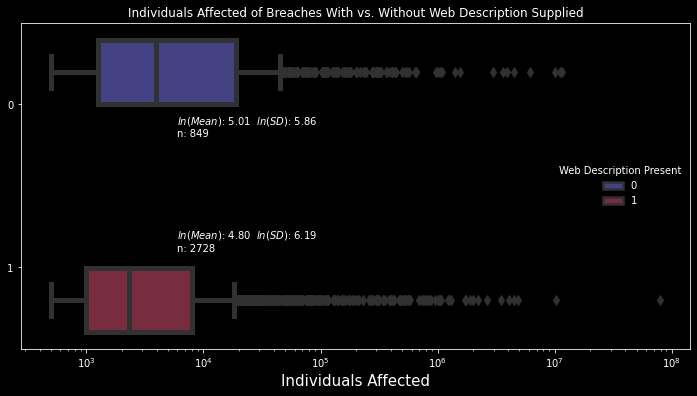

In [68]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.boxplot(
        x = "individuals_affected", 
        y = "web_description_present", 
        data = data, 
    hue = "web_description_present", linewidth = 5, 
    orient = "h", saturation = 99e-1, fliersize = 7, 
    ax = ax, palette = "icefire")
ax.set(xscale = "log")
ax.set_title("Individuals Affected of Breaches With" + 
    " vs. Without Web Description Supplied")
ax.set_xlabel("Individuals Affected", fontsize = 15)
ax.set_ylabel("")
x_coord = 6e3
ax.annotate("$ln({Mean})$: %.2f" % np.log10(absent.loc["mean"]) +
    "  $ln({SD})$: %.2f" % np.log10(absent.loc["std"]) + 
    "\nn: %d" % absent.loc["count"],
    xy = (x_coord, 2e-1))
ax.annotate("$ln({Mean})$: %.2f" % np.log10(present.loc["mean"]) +
    "  $ln({SD})$: %.2f" % np.log10(present.loc["std"]) + 
    "\nn: %d" % present.loc["count"],
    xy = (x_coord, 9e-1) )
ax.legend(fontsize = 10, title = "Web Description Present", 
    frameon = 0)
plt.show(); 

## for medical data breaches that have a web description supplied by HHS, the sample mean is 103,021 whereas the sample mean for breaches with a web description is only 63,289. the sample sizes are different though: 849 breaches don't have a web description present while 2728 do have one. moreover, while minimal values are the same between these two factors, breaches sans web description has a higher 25th percentile, median, and 75th percentile of the 2 vectors.

## using tfidf to predict if ln(1 + Individuals Affected) is above its median. "None" is assigned to absent web descriptions rather than making the task artificially easier by dropping observations without a web description

In [69]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

## corpus map is assigned pertinent vectors for modelling and for matching observations, corpus is input / X 

In [70]:
corpus_map = dict(data[['breach_id', 'web_description', 
               'log1p_ia_gt50']].items())
corpus = corpus_map['web_description']
corpus
corpus.shape

0                                                       1
1                                                       0
2                                                       0
3                                                       0
4                                                       0
                              ...                        
3573    Between January 1, 2015 and April 18, 2015, a ...
3574    Over a period of about three and half years, a...
3575    The covered entity (CE), North Carolina Depart...
3576    The covered entity (CE), University of Rochest...
3577    The covered entity (CE), Metropolitan Governme...
Name: web_description, Length: 3577, dtype: object

(3577,)

In [71]:
y = corpus_map['log1p_ia_gt50']
y, y.shape, y.unique()

(0       1
 1       0
 2       1
 3       1
 4       1
        ..
 3573    1
 3574    0
 3575    0
 3576    1
 3577    0
 Name: log1p_ia_gt50, Length: 3577, dtype: int64,
 (3577,),
 array([1, 0]))

In [72]:
target_names = tuple(map(lambda i: y.name + "_" + str(i) , 
                    range(len(y.unique()))))
target_names

('log1p_ia_gt50_0', 'log1p_ia_gt50_1')

In [73]:
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, 
                                        test_size = 3e-1, random_state = 54)

### pipe_tup is assigned two steps that will be common to all text analysis pipelines 

# tfidf or $TermFrequency * DocumentFrequency^{-1}$ is used to assign coefficients to rows  
## if language (kept simple as (1, 1) ngrams) is used frequently in one web description and is not used in any other web description, the ngram is assigned a higher tfidf coefficient than if the ngram were used frequently in the web decription we happen to be looking at and also shows up in many other web descriptions

In [74]:
pipe_tup = (('count', CountVectorizer()),
                ('tfidf', TfidfTransformer()))

In [75]:
def get_pipe(model, steps_vector = pipe_tup) -> Pipeline:
    pipe = [*steps_vector]
    pipe.insert(len(pipe), model)
    return Pipeline(pipe)

In [76]:
mnb_pipe = get_pipe(('mnb', MultinomialNB()))
mnb_pipe.fit(corpus_train, y_train)
mnb_y_predicted = mnb_pipe.predict(corpus_test)
np.mean(mnb_y_predicted == y_test)

Pipeline(steps=[('count', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('mnb', MultinomialNB())])

0.6098696461824954

In [77]:
from sklearn.model_selection import cross_val_score

In [78]:
# not a good model 
mnb_cv_f1 = cross_val_score(mnb_pipe, corpus, y, cv = 15, n_jobs = -1, 
                    scoring = 'f1', verbose = 1).mean()
mnb_cv_f1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.1s finished


0.5505873025397091

In [79]:
from sklearn.svm import SVC

In [80]:
svm_pipe = get_pipe(('svm', SVC(C = 3, gamma = 3e-3, 
            class_weight = 'balanced')))
svm_pipe.fit(corpus_train, y_train)
svm_predicted = svm_pipe.predict(corpus_test)
np.mean(svm_predicted == y_test)

Pipeline(steps=[('count', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('svm', SVC(C=3, class_weight='balanced', gamma=0.003))])

0.5502793296089385

In [81]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [82]:
def get_scores_map(y_true, y_hat, target_names = target_names) -> dict:
    return {'confusion_matrix' : confusion_matrix(y_true, y_hat), 
            'clf_report' : classification_report(y_true, y_hat, 
                target_names = target_names)}

In [83]:
svm_scores_map = get_scores_map(y_test, svm_predicted)
svm_scores_map['confusion_matrix'] 
svm_scores_map['confusion_matrix'].trace() / svm_scores_map['confusion_matrix'].sum()
print(svm_scores_map['clf_report'])

array([[438,  96],
       [387, 153]])

0.5502793296089385

                 precision    recall  f1-score   support

log1p_ia_gt50_0       0.53      0.82      0.64       534
log1p_ia_gt50_1       0.61      0.28      0.39       540

       accuracy                           0.55      1074
      macro avg       0.57      0.55      0.52      1074
   weighted avg       0.57      0.55      0.52      1074



## lengthy support vector machine grid search is commented out for the sake of time

In [84]:
#from sklearn.model_selection import GridSearchCV

#svm_hyperparams = dict(count__ngram_range = [(1, 3), (1, 4)], 
#                    #count__stop_words = ['english', None], 
#                    svm__C = np.logspace(-5, 5, 2), 
#                    svm__gamma = np.logspace(-5, 5, 2))

#gs_svm = GridSearchCV(svm_pipe, svm_hyperparams, cv = 3, verbose = 1, 
#            n_jobs = -1,
#            scoring = 'f1')
#gs_svm = gs_svm.fit(corpus, y)
#harmonic_mean = cross_val_score(gs_svm, corpus, y, cv = 3, scoring = 'f1', 
#                    n_jobs = -1, verbose = 1).mean()
#harmonic_mean
#gs_svm.best_params_


 ## before building a neural network, evaluate how well logistic regression does using heavy regularization to keep model complexity and variance low

In [85]:
from sklearn.linear_model import LogisticRegression

In [86]:
logit_pipe = get_pipe(('logit', LogisticRegression(C = 1e5, 
    random_state = 37, class_weight = 'balanced', n_jobs = -1)))
logit_pipe.fit(corpus_train, y_train)
logit_y_pred = logit_pipe.predict(corpus_test)
logit_scores_map = get_scores_map(y_test, logit_y_pred)
logit_scores_map['confusion_matrix']
print(logit_scores_map['clf_report'])

Pipeline(steps=[('count', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('logit',
                 LogisticRegression(C=100000.0, class_weight='balanced',
                                    n_jobs=-1, random_state=37))])

array([[316, 218],
       [208, 332]])

                 precision    recall  f1-score   support

log1p_ia_gt50_0       0.60      0.59      0.60       534
log1p_ia_gt50_1       0.60      0.61      0.61       540

       accuracy                           0.60      1074
      macro avg       0.60      0.60      0.60      1074
   weighted avg       0.60      0.60      0.60      1074



 ## of multinomial naive bayes, support vector machine, and logistic regression, logistic regression is the clear winner

In [87]:
logit_cv_f1 = cross_val_score(logit_pipe, corpus, y, cv = 5, n_jobs = -1, 
                    verbose = 1, scoring = 'f1')
logit_cv_f1
logit_cv_f1.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


array([0.59757739, 0.55506608, 0.66010929, 0.59138187, 0.60699301])

0.6022255274166552

In [88]:
corpus_train

620                                                  None
1821    On April 19, 2013, the credit card information...
1329                                                   \N
1590    On May 27, 2015, the U.S. Department of Justic...
1817    Health Care Service Corporation, a business as...
                              ...                        
3393    This review has been consolidated with another...
1047    Alleged hackers gained unauthorized access to ...
898     Lahey Hospital and Medical Center (Lahey)  has...
3398    The covered entity (CE), Ohio Living, reported...
3184    A third-line sub-contractor of Windsor Health ...
Name: web_description, Length: 2503, dtype: object

In [89]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model 
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense
from keras import models

 ## prepare corpus for simple neural net and continue using tfidf to assign coefficients to feature matrix X

In [90]:
print("pipe_tup: ", pipe_tup)
X = corpus
nn_pipe = Pipeline(pipe_tup).fit(corpus)
tokenizer = Tokenizer(num_words = nn_pipe['tfidf'].idf_.shape[0])
tokenizer.fit_on_texts(X)
print("\ntokenizer", tokenizer)
print("\nX", X)

pipe_tup:  (('count', CountVectorizer()), ('tfidf', TfidfTransformer()))

tokenizer <keras_preprocessing.text.Tokenizer object at 0x7f40085f0a60>

X 0                                                       1
1                                                       0
2                                                       0
3                                                       0
4                                                       0
                              ...                        
3573    Between January 1, 2015 and April 18, 2015, a ...
3574    Over a period of about three and half years, a...
3575    The covered entity (CE), North Carolina Depart...
3576    The covered entity (CE), University of Rochest...
3577    The covered entity (CE), Metropolitan Governme...
Name: web_description, Length: 3577, dtype: object


In [91]:
X = tokenizer.texts_to_matrix(X, mode = 'tfidf')
X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 3.94531435, 2.81031358, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.83406403, 2.96548875, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.77342596, 3.50806743, ..., 0.        , 0.        ,
        0.        ]])

 ## build a sequential neural net while avoiding hyperparameter tuning

In [92]:
nn = Sequential(
    [
    # build input layer with ReLU activation 
    Dense(units = 64, kernel_initializer = "uniform", 
        activation = 'relu', input_shape = (X.shape[1],)), 
    # build 2 fully connected layers with ReLU activation functions
    Dense(units = 32, kernel_initializer = "uniform", 
        activation = "relu"),
    Dense(units = 16, kernel_initializer = "uniform", 
        activation = "relu"),
    # build axon with sigmoid activation function 
    Dense(units = 1, kernel_initializer = "uniform", 
        activation = "sigmoid")
    ]
)

In [93]:
nn.compile(loss = "binary_crossentropy", optimizer = "rmsprop", 
    metrics = ['accuracy'])
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                489344    
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 491,969
Trainable params: 491,969
Non-trainable params: 0
_________________________________________________________________


# create callback functions to stop training early and assign best model if after 2 epochs test loss is unimproved

In [94]:
callbacks = [EarlyStopping(monitor = "val_loss", patience = 2), 
                ModelCheckpoint(filepath = "best_nn_early_stop.h5", 
                    monitor = "val_loss", save_best_only = True)]

In [95]:
history = nn.fit(X, y, epochs = 32, verbose = 1, callbacks = callbacks,
    batch_size = 1024, validation_split = 1e-1)

Epoch 1/32
4/4 [==============================] - 0s 106ms/step - loss: 0.6931 - accuracy: 0.4849 - val_loss: 0.6926 - val_accuracy: 0.6257
Epoch 2/32
4/4 [==============================] - 0s 64ms/step - loss: 0.6916 - accuracy: 0.6372 - val_loss: 0.6875 - val_accuracy: 0.6480
Epoch 3/32
4/4 [==============================] - 0s 64ms/step - loss: 0.6817 - accuracy: 0.6375 - val_loss: 0.6761 - val_accuracy: 0.6732
Epoch 4/32
4/4 [==============================] - 0s 69ms/step - loss: 0.6500 - accuracy: 0.7021 - val_loss: 0.6630 - val_accuracy: 0.6397
Epoch 5/32
4/4 [==============================] - 0s 64ms/step - loss: 0.5991 - accuracy: 0.7375 - val_loss: 0.6542 - val_accuracy: 0.6369
Epoch 6/32
4/4 [==============================] - 0s 53ms/step - loss: 0.5375 - accuracy: 0.7655 - val_loss: 0.6729 - val_accuracy: 0.6229
Epoch 7/32
4/4 [==============================] - 0s 52ms/step - loss: 0.4929 - accuracy: 0.7695 - val_loss: 0.6684 - val_accuracy: 0.6285


In [96]:
def plot_history(history, loss = True):
    """plot loss or accuracy of simple sequential model as a function
    of epoch 
    """
    y_label = "loss"
    if not loss:
        y_label = "accuracy"
    train_history = history.history[y_label]
    test_history = history.history["val_" + y_label]
    # get n epochs to use as x-label
    n_epochs = range(1, len(train_history) + 1)
    # plot loss or accuracy history 
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.plot(n_epochs, train_history, color = "hotpink", 
        label = "Train " + y_label.capitalize())
    ax.plot(n_epochs, test_history, color = "steelblue", 
        label = "Test " + y_label.capitalize())
    ax.legend()
    ax.set_xlabel("Epochs"), ax.set_ylabel(y_label.capitalize())
    plt.show();

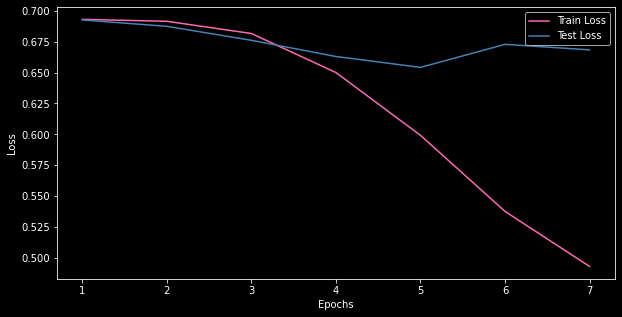

In [97]:
plot_history(history)

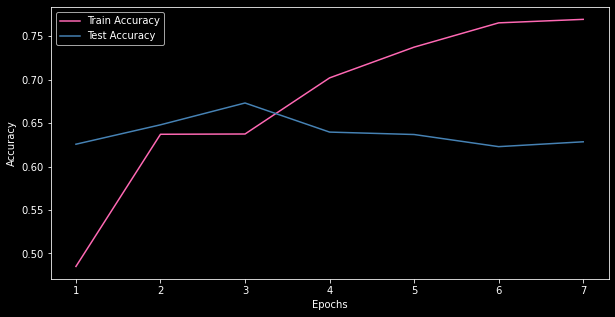

In [98]:
plot_history(history, False)

## no more than about 3-4 epochs is optimal it looks like! 

# The following is the impetus for the next part of this notebook: 
## "As we saw earlier, with thick tailed distributions, extreme events away from the centre of the distribution play a very large role. Black Swans are not "more frequent" (as it is commonly misinterpreted), they are more consequential. The fattest tail distribution has just one very large extreme deviation, rather than many departures form the norm. Figure 4.4 shows that if we take a distribution such as the Gaussian and start fattening its tails, then the number of departures away from one standard deviation drops. The probability of an event staying within one standard deviation of the mean is 68 percent. As the tails fatten, to mimic what happens in financial markets for example, the probability of an event staying within one standard deviation of the mean rises to between 75 and 95 percent. So note that as we fatten the tails we get higher peaks, smaller shoulders, and a higher incidence of a very large deviation."
 - Statistical Consequences of Thick Tails (Technical Incerto Collection). Copyright
 Nassim Nicholas Taleb, 2019

# sum daily values and interpolate where necessary to create a time series of individuals affected vector 

In [99]:
ts = data[['individuals_affected', 'breach_submission_date']].groupby(
    'breach_submission_date').apply(
        lambda g: g.sum())[['individuals_affected']].diff().dropna()
ts.head(5)
ts.resample('D').asfreq().interpolate(method = 'cubic', inplace = True)
ts.head(5)

,individuals_affected
breach_submission_date,
2009-10-28,0.0
2009-10-30,-499.0
2009-11-17,3299.0
2009-11-20,14577.0
2009-11-23,-12477.0


,individuals_affected
breach_submission_date,
2009-10-28,0.0
2009-10-30,-499.0
2009-11-17,3299.0
2009-11-20,14577.0
2009-11-23,-12477.0


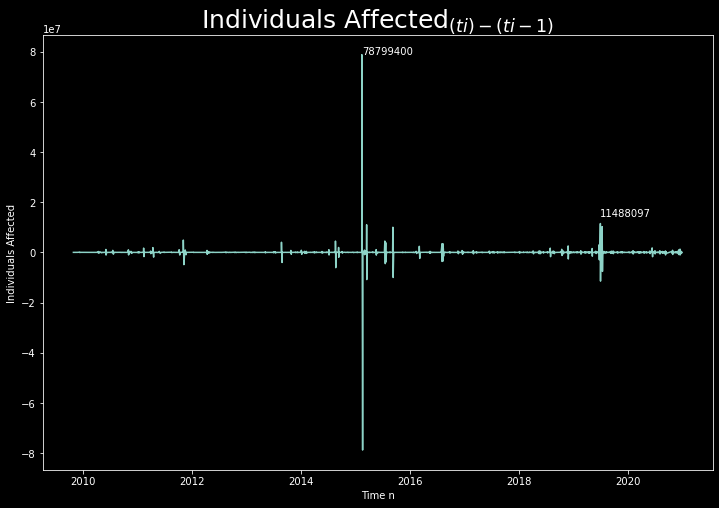

In [100]:
ts_y = r'Individuals Affected$_{(ti) - (ti-1)}$'
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(ts.index, ts.individuals_affected)
ax.set_xlabel('Time n'), ax.set_ylabel('Individuals Affected')
ax.set_title(ts_y, fontsize = 25)
date_idx_annot1 = anthem_breach2015.breach_submission_date 
y_annot1 = ts[date_idx_annot1 == ts.index].individuals_affected[0]
ax.annotate(xy = (ts.index[date_idx_annot1 == ts.index], y_annot1),  
    text = y_annot1.astype("int"))
ia_sorted = ts.sort_values(by = "individuals_affected", 
            ascending = 0)
ax.annotate(xy = (ia_sorted.index[1], 
    5 * ia_sorted.to_numpy()[1, 0] / 4), 
    text = ia_sorted.to_numpy()[1, 0].astype("int"), fontsize = 10)
plt.show(); 

# calculate ratio of maximum-to-sum for 4th moment individuals_affected$^4$ as time series and as pooled cross-section.
##    Results based on this time series may understate the MS ratio relative to a time series that doesn't interpolate. there's room for exploring alternative  time series generation strategies as the data set isn't a time series in the first place.
##    Nassim Taleb in his *Technical Incerto Collection* and Embrechts, Kluppelberg, and Mikosch in *Modelling Extreme Events for Insurance and Finance* cite calculation of Maximum-to-Sum as a simple method to detect fat tails in a distribution.
 - Statistical Consequences of Thick Tails (Technical Incerto Collection). Copyright
 Nassim Nicholas Taleb, 2019
 - Embrechts, Paul, et al. Modelling Extremal Events for Insurance and Finance.
 1st ed., Springer, 2012.

In [101]:
from sklearn.preprocessing import StandardScaler

 standardize each of individuals affected (pooled cross-section) and
 individuals affected (time series) so each element is the original
 observation's distance from its vector's mean in terms of the vector's
 standard deviation

In [102]:
scaler = StandardScaler()
ia = data.individuals_affected.to_numpy().reshape(-1, 1)
ia_ts = ts.individuals_affected.to_numpy().reshape(-1, 1)
ia4 = scaler.fit_transform(ia) ** 4
ia4_ts = scaler.fit_transform(ia_ts) ** 4
ia4, ia4_ts

(array([[6.25285655e-06],
        [7.20001189e-06],
        [4.72742351e-06],
        ...,
        [7.00675287e-06],
        [6.50507349e-06],
        [6.85017829e-06]]),
 array([[2.36643218e-34],
        [1.19264938e-15],
        [2.27823047e-12],
        ...,
        [1.07876441e-03],
        [1.39829588e-12],
        [1.06526611e-12]]))

# Plot pooled-cross section distribution of individuals affected

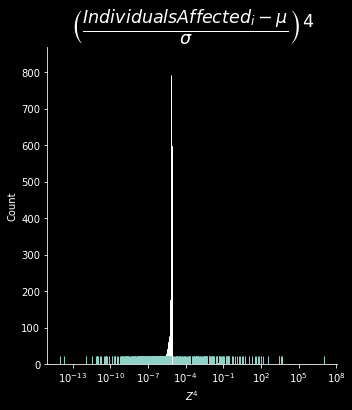

In [103]:
title = r"$\left(\frac{IndividualsAffected_{i} - \mu}{\sigma} \right)^4$"
g = sns.displot(ia4, rug = True, color = 'hotpink', log_scale = True, 
    legend = False)
g.ax.set_title(title, fontsize = 25)
g.set_xlabels("$Z^4$")
plt.show(); 

In [104]:
def max_to_sum(X: np.ndarray):
    """return the ratio of maximum to sum considering 
    only data up to index i: returns partial maximum to 
    sum. X is assumed to be one feature   
    """
    n = len(X)
    return tuple(max(X[:i]) / sum(X[:i]) for i in range(1, n + 1))

In [105]:
partial_max_to_sum_ts = np.array(max_to_sum(ia4_ts))
partial_max_to_sum_ts

array([[1.        ],
       [1.        ],
       [0.99947678],
       ...,
       [0.49936051],
       [0.49936051],
       [0.49936051]])

 evident in the time series max-to-sum plot is moderation and maybe
 convergence after ~time n = 775 although this could be due to interpolation
 and calculation using pooled cross-section could yield different results

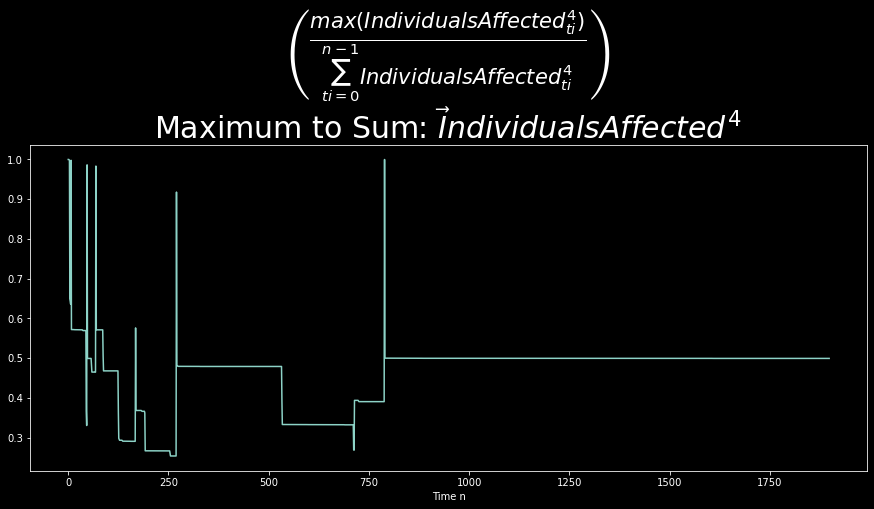

In [106]:
ts_y = r'$\left(\frac{max(IndividualsAffected_{ti}^4)}{\sum_{ti=0}^{n-1} IndividualsAffected_{ti}^4}\right)$' 
fig, ax = plt.subplots(figsize = (15, 6))
ax.plot(range(len(partial_max_to_sum_ts)), partial_max_to_sum_ts)
ax.set_title(ts_y + "\n" + "Maximum to Sum: " + r"$\vec IndividualsAffected^{4}$ ",
    fontsize = 30)
ax.set_xlabel("Time n")
plt.show(); 

In [107]:
partial_max_to_sum_cs = np.array(tuple(max_to_sum(ia4)))
partial_max_to_sum_cs 

array([[1.        ],
       [0.53520273],
       [0.3960339 ],
       ...,
       [0.99856099],
       [0.99856099],
       [0.99856099]])

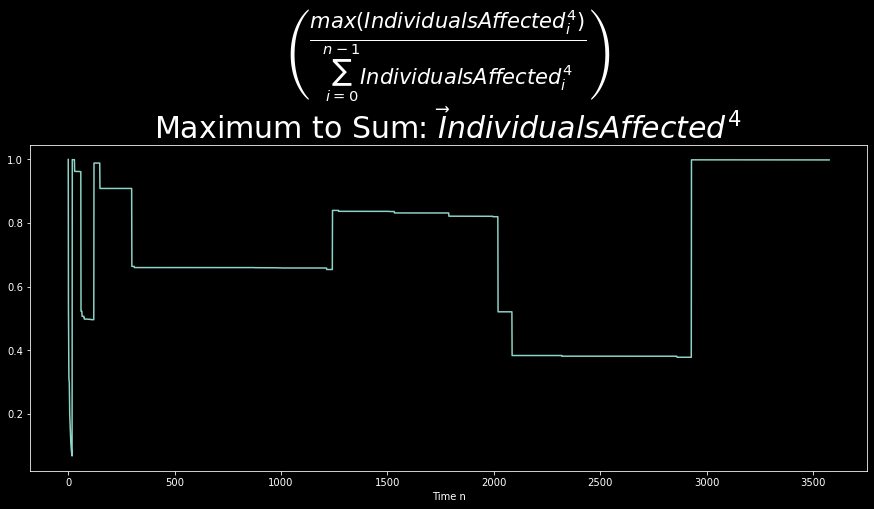

In [108]:
cs_y = r'$\left(\frac{max(IndividualsAffected_{i}^4)}{\sum_{i=0}^{n-1} IndividualsAffected_{i}^4}\right)$' 
fig, ax = plt.subplots(figsize = (15, 6))
ax.plot(range(len(partial_max_to_sum_cs)), partial_max_to_sum_cs)
ax.set_title(cs_y + "\n" + "Maximum to Sum: " + r"$\vec IndividualsAffected^{4}$ ",
    fontsize = 30)
ax.set_xlabel("Time n")
plt.show(); 

 ## when calculated using the pooled cross-section there are large deviations when n is large and probably more importantly, when n is at its max M/S is close to 1. According to Embrechts, et. al this may indicate that the 4th moment is infinite
 - Embrechts, Paul, et al. Modelling Extremal Events for Insurance and Finance.
 1st ed., Springer, 2012.

## further explore the impact of extremal values on individuals_affected vector

In [109]:
mask = data.individuals_affected != data.individuals_affected.max()
inds_affected_no_max = data[mask][['individuals_affected']]
inds_affected_no_max

,individuals_affected
0,3317.0
1,828.0
2,8000.0
3,137110.0
4,114834.0
...,...
3573,4223.0
3574,647.0
3575,1315.0
3576,2628.0


In [110]:
inds_affected_no_max_summary = inds_affected_no_max.describe().T
inds_affected_no_max_summary['mean_absolute_dev'] = inds_affected_no_max.mad()
inds_affected_no_max_summary['skewness'] = inds_affected_no_max.skew()
inds_affected_no_max_summary['kurtosis'] = inds_affected_no_max.kurtosis()
inds_affected_no_max_summary = inds_affected_no_max_summary.T
inds_affected_no_max_summary.rename({'individuals_affected': 'individuals_affected_no_max'}, 
        axis = 1, inplace = True)
inds_affected_no_max_summary

,individuals_affected_no_max
count,3.576000e+03
mean,5.065211e+04
std,4.361749e+05
min,5.000000e+02
25%,1.000750e+03
50%,2.600000e+03
75%,1.000000e+04
max,1.150000e+07
mean_absolute_dev,8.193543e+04
skewness,1.916196e+01


## summary_compare is assigned vectors individuals_affected, individuals_affected without the 2015 anthem breach, and the proportion of each parameter i.e., count, mean, std, etc. that the 2015 anthem data breach contributes to the original summary the 2015 anthem data breach is responsible for 68.61% of the variance of the individuals_affected vector, %.02 of its size, %33.67 of its mean absolute deviation, %62.78 of its skewness, and %85.126 of its sample kurtosis, or empirical propensity to generate outliers contributing disproportionately to expected value. the mean is %30.69 lower without the 2015 anthem breach. this is inconsistent with a normal distribution. considering that the 2015 anthem breach is only one observation of the 3500+ is likely critical to narrowing down viable distributions to model the process generating the data. there's evidence contradicting the hypothesis of a normal distribution.

In [111]:
summary_compare = pd.concat((inds_affected_summary, inds_affected_no_max_summary), axis = 1)
w = summary_compare['individuals_affected'].to_numpy()
wo = summary_compare['individuals_affected_no_max'].to_numpy()
summary_compare['with_max_to_without_max'] = w / wo
summary_compare['impact_of_max'] = (w - wo) / w
summary_compare

,individuals_affected,individuals_affected_no_max,with_max_to_without_max,impact_of_max
count,3.577000e+03,3.576000e+03,1.000280,0.000280
mean,7.266758e+04,5.065211e+04,1.434641,0.302961
std,1.387047e+06,4.361749e+05,3.180025,0.685537
min,5.000000e+02,5.000000e+02,1.000000,0.000000
25%,1.001000e+03,1.000750e+03,1.000250,0.000250
50%,2.600000e+03,2.600000e+03,1.000000,0.000000
75%,1.000000e+04,1.000000e+04,1.000000,0.000000
max,7.880000e+07,1.150000e+07,6.852174,0.854061
mean_absolute_dev,1.227103e+05,8.193543e+04,1.497647,0.332286
skewness,5.175309e+01,1.916196e+01,2.700824,0.629743


# Add external components to feature space for modelling using continuous features. wbdata is used to access world bank python api
see sources.md for citation

In [112]:
import wbdata

In [113]:
wb_indicators = ["IT.NET.USER.ZS", "IT.MLT.MAIN.P2", 
                "IT.NET.SECR.P6", "IT.CEL.SETS.P2", 
                "IT.NET.BBND.P2", "BM.GSR.ROYL.CD",
                "BM.GSR.TRAN.ZS", "BM.GSR.CMCP.ZS",
                "BM.GSR.FCTY.CD", "BM.GSR.TOTL.CD", 
                "BM.GSR.INSF.ZS"]

In [114]:
def getInternetMetadata(wb_indicators = wb_indicators) -> dict: 
    """fetch metadata from world bank for each indicator 
    given in wb_indicators"""
    f = lambda ind: wbdata.get_indicator(ind).pop().items()
    inet_metadata = list(map(f, wb_indicators))
    wb_indicators_map = dict(zip(wb_indicators, inet_metadata))
    unpacked_map = {k: dict(wb_indicators_map[k]) for k in wb_indicators_map.keys()}
    return unpacked_map

In [115]:
internet_metadata = getInternetMetadata()
for k in internet_metadata.keys():
    name = internet_metadata[k]["name"]
    source_org = internet_metadata[k]["sourceOrganization"]
    source_note = internet_metadata[k]["sourceNote"]
    name, source_org, source_note

('Individuals using the Internet (% of population)',
 'International Telecommunication Union (ITU) World Telecommunication/ICT Indicators Database',
 'Internet users are individuals who have used the Internet (from any location) in the last 3 months. The Internet can be used via a computer, mobile phone, personal digital assistant, games machine, digital TV etc.')

('Fixed telephone subscriptions (per 100 people)',
 'International Telecommunication Union (ITU) World Telecommunication/ICT Indicators Database',
 'Fixed telephone subscriptions refers to the sum of active number of analogue fixed telephone lines, voice-over-IP (VoIP) subscriptions, fixed wireless local loop (WLL) subscriptions, ISDN voice-channel equivalents and fixed public payphones.')

('Secure Internet servers (per 1 million people)',
 'Netcraft (http://www.netcraft.com/) and World Bank population estimates.',
 'The number of distinct, publicly-trusted TLS/SSL certificates found in the Netcraft Secure Server Survey.')

('Mobile cellular subscriptions (per 100 people)',
 'International Telecommunication Union (ITU) World Telecommunication/ICT Indicators Database',
 'Mobile cellular telephone subscriptions are subscriptions to a public mobile telephone service that provide access to the PSTN using cellular technology. The indicator includes (and is split into) the number of postpaid subscriptions, and the number of active prepaid accounts (i.e. that have been used during the last three months). The indicator applies to all mobile cellular subscriptions that offer voice communications. It excludes subscriptions via data cards or USB modems, subscriptions to public mobile data services, private trunked mobile radio, telepoint, radio paging and telemetry services.')

('Fixed broadband subscriptions (per 100 people)',
 'International Telecommunication Union (ITU) World Telecommunication/ICT Indicators Database',
 'Fixed broadband subscriptions refers to fixed subscriptions to high-speed access to the public Internet (a TCP/IP connection), at downstream speeds equal to, or greater than, 256 kbit/s. This includes cable modem, DSL, fiber-to-the-home/building, other fixed (wired)-broadband subscriptions, satellite broadband and terrestrial fixed wireless broadband. This total is measured irrespective of the method of payment. It excludes subscriptions that have access to data communications (including the Internet) via mobile-cellular networks. It should include fixed WiMAX and any other fixed wireless technologies. It includes both residential subscriptions and subscriptions for organizations.')

('Charges for the use of intellectual property, payments (BoP, current US$)',
 'International Monetary Fund, Balance of Payments Statistics Yearbook and data files.',
 'Charges for the use of intellectual property are payments and receipts between residents and nonresidents for the authorized use of proprietary rights (such as patents, trademarks, copyrights, industrial processes and designs including trade secrets, and franchises) and for the use, through licensing agreements, of produced originals or prototypes (such as copyrights on books and manuscripts, computer software, cinematographic works, and sound recordings) and related rights (such as for live performances and television, cable, or satellite broadcast). Data are in current U.S. dollars.')

('Transport services (% of service imports, BoP)',
 'International Monetary Fund, Balance of Payments Statistics Yearbook and data files.',
 'Transport covers all transport services (sea, air, land, internal waterway, pipeline, space and electricity transmission) performed by residents of one economy for those of another and involving the carriage of passengers, the movement of goods (freight), rental of carriers with crew, and related support and auxiliary services. Also included are postal and courier services. Excluded are freight insurance (included in insurance services); goods procured in ports by nonresident carriers (included in goods); maintenance and repairs on transport equipment (included in maintenance and repair services n.i.e.); and repairs of railway facilities, harbors, and airfield facilities (included in construction).')

('Communications, computer, etc. (% of service imports, BoP)',
 'International Monetary Fund, Balance of Payments Statistics Yearbook and data files.',
 'Communications, computer, information, and other services cover international telecommunications; computer data; news-related service transactions between residents and nonresidents; construction services; royalties and license fees; miscellaneous business, professional, and technical services; personal, cultural, and recreational services; manufacturing services on physical inputs owned by others; and maintenance and repair services and government services not included elsewhere.')

('Primary income payments (BoP, current US$)',
 'International Monetary Fund, Balance of Payments Statistics Yearbook and data files.',
 'Primary income payments refer to employee compensation paid to nonresident workers and investment income (payments on direct investment, portfolio investment, other investments). Data are in current U.S. dollars.')

('Imports of goods, services and primary income (BoP, current US$)',
 'International Monetary Fund, Balance of Payments Statistics Yearbook and data files.',
 'Imports of goods, services and primary income is the sum of goods imports, service imports and primary income payments. Data are in current U.S. dollars.')

('Insurance and financial services (% of service imports, BoP)',
 'International Monetary Fund, Balance of Payments Statistics Yearbook and data files.',
 'Insurance and financial services cover various types of insurance provided to nonresidents by resident insurance enterprises and vice versa, and financial intermediary and auxiliary services (except those of insurance enterprises and pension funds) exchanged between residents and nonresidents.')

 assign more meaningful column names to wb data

In [116]:
wb_col_names = ('pct_pop_using_inet', 'fixed_phone_subs_per_100', 
                    'secure_servers_per_mil', 'mobile_cell_subs_per_100', 
                    'fixed_bbnd_subs_per_100', "ip_payments", 
                    "transpt_pct_serv_imports", "comm_pct_serv_imports",
                    "prim_income_pmts", "igs_primary_income", 
                    "insfin_pct_serv_imports")
retrieve_wb = dict(zip([*internet_metadata.keys()], wb_col_names))
retrieve_wb
data_date = str(data.breach_submission_date.min().year - 5)

{'IT.NET.USER.ZS': 'pct_pop_using_inet',
 'IT.MLT.MAIN.P2': 'fixed_phone_subs_per_100',
 'IT.NET.SECR.P6': 'secure_servers_per_mil',
 'IT.CEL.SETS.P2': 'mobile_cell_subs_per_100',
 'IT.NET.BBND.P2': 'fixed_bbnd_subs_per_100',
 'BM.GSR.ROYL.CD': 'ip_payments',
 'BM.GSR.TRAN.ZS': 'transpt_pct_serv_imports',
 'BM.GSR.CMCP.ZS': 'comm_pct_serv_imports',
 'BM.GSR.FCTY.CD': 'prim_income_pmts',
 'BM.GSR.TOTL.CD': 'igs_primary_income',
 'BM.GSR.INSF.ZS': 'insfin_pct_serv_imports'}

 fetch data for China and United States.
 China is included for its impact in telecommunications, notwithstanding
 all HHS data being confined to U.S. enterprises

In [117]:
inet_config = {'indicators': retrieve_wb, 'country': ['US', 'CN'], 'convert_date': 1, 
                'data_date': (pd.to_datetime(data_date), data.breach_submission_date.max())  }  
inet_config
internet_data = wbdata.get_dataframe(**inet_config)
internet_data.sample(10)

{'indicators': {'IT.NET.USER.ZS': 'pct_pop_using_inet',
  'IT.MLT.MAIN.P2': 'fixed_phone_subs_per_100',
  'IT.NET.SECR.P6': 'secure_servers_per_mil',
  'IT.CEL.SETS.P2': 'mobile_cell_subs_per_100',
  'IT.NET.BBND.P2': 'fixed_bbnd_subs_per_100',
  'BM.GSR.ROYL.CD': 'ip_payments',
  'BM.GSR.TRAN.ZS': 'transpt_pct_serv_imports',
  'BM.GSR.CMCP.ZS': 'comm_pct_serv_imports',
  'BM.GSR.FCTY.CD': 'prim_income_pmts',
  'BM.GSR.TOTL.CD': 'igs_primary_income',
  'BM.GSR.INSF.ZS': 'insfin_pct_serv_imports'},
 'country': ['US', 'CN'],
 'convert_date': 1,
 'data_date': (Timestamp('2004-01-01 00:00:00'),
  Timestamp('2020-12-30 00:00:00'))}

pct_pop_using_inet  fixed_phone_subs_per_100  \
country       date                                                       
China         2005-01-01             8.52326                   26.3339   
              2004-01-01             7.30000                   23.5628   
              2007-01-01            16.00000                   27.1648   
              2014-01-01            47.90000                   17.8234   
              2015-01-01            50.30000                   16.4194   
              2020-01-01                 NaN                       NaN   
United States 2012-01-01            74.70000                   44.1324   
              2019-01-01            87.26610                   32.6018   
              2013-01-01            71.40000                   42.1090   
              2014-01-01            73.00000                   40.3218   

                          secure_servers_per_mil  mobile_cell_subs_per_100  \
country       date                                                           
China         2005-01-01                     NaN                   29.5621   
              2004-01-01                     NaN                   25.3063   
              2007-01-01                     NaN                   40.6618   
              2014-01-01                9.759065                   91.8996   
              2015-01-01               19.682473                   91.8354   
              2020-01-01                     NaN                       NaN   
United States 2012-01-01             3842.268732                   97.0686   
              2019-01-01           124014.176075                  123.6880   
              2013-01-01             4304.028642                   98.1977   
              2014-01-01             5130.919975                  111.5560   

                          fixed_bbnd_subs_per_100   ip_payments  \
country       date                                                
China         2005-01-01                  2.80663  5.321254e+09   
              2004-01-01                  1.88496  4.496605e+09   
              2007-01-01                  4.93420  8.192067e+09   
              2014-01-01                 14.32580  2.261380e+10   
              2015-01-01                 19.69270  2.202237e+10   
              2020-01-01                      NaN           NaN   
United States 2012-01-01                 29.45890  3.506100e+10   
              2019-01-01                 34.67190  4.273200e+10   
              2013-01-01                 30.35140  3.529400e+10   
              2014-01-01                 30.69290  3.756200e+10   

                          transpt_pct_serv_imports  comm_pct_serv_imports  \
country       date                                                          
China         2005-01-01                 33.885220              31.438266   
              2004-01-01                 33.676663              30.649828   
              2007-01-01                 33.514414              34.728099   
              2014-01-01                 22.213339              18.939834   
              2015-01-01                 19.585945              20.451268   
              2020-01-01                       NaN                    NaN   
United States 2012-01-01                 21.150058              42.681283   
              2019-01-01                 18.264405              16.504267   
              2013-01-01                 20.273197              43.760533   
              2014-01-01                 20.330393              43.069073   

                          prim_income_pmts  igs_primary_income  \
country       date                                               
China         2005-01-01      5.538664e+10        7.040988e+11   
              2004-01-01      2.568907e+10        5.792894e+11   
              2007-01-01      7.543181e+10        1.024448e+12   
              2014-01-01      2.260711e+11        2.467674e+12   
              2015-01-01      2.642566e+11        2.266538e+12   
        

In [118]:
def getNatData(c_name = 'China') -> pd.DataFrame:
    """returns df for cn or us with column names altered to reflect which"""
    suffix = '_us'
    inet_data_grouped = internet_data.loc['United States']
    if c_name.lower() == 'china':
         suffix = '_cn'
         inet_data_grouped = internet_data.loc['China'] 
    inet_data_grouped.columns = tuple(map(lambda c: c + suffix, inet_data_grouped.columns))
    return inet_data_grouped

In [119]:
inet_data_us = getNatData('United States')
inet_data_cn = getNatData('China')

In [120]:
wb_plot_map = {v: internet_metadata[k]['name']
                    for k, v in retrieve_wb.items()}
n = inet_data_cn.columns.size 
world_bank_dfs = (inet_data_cn, inet_data_us)
source_map = {v: internet_metadata[k]["sourceOrganization"] for k, v in 
retrieve_wb.items()}
plt_colors = ('violet', 'forestgreen', 'orange', 'indigo', 'red', 
                'hotpink', 'steelblue', 'teal', 'ghostwhite', 
                'slategrey', 'rosybrown')

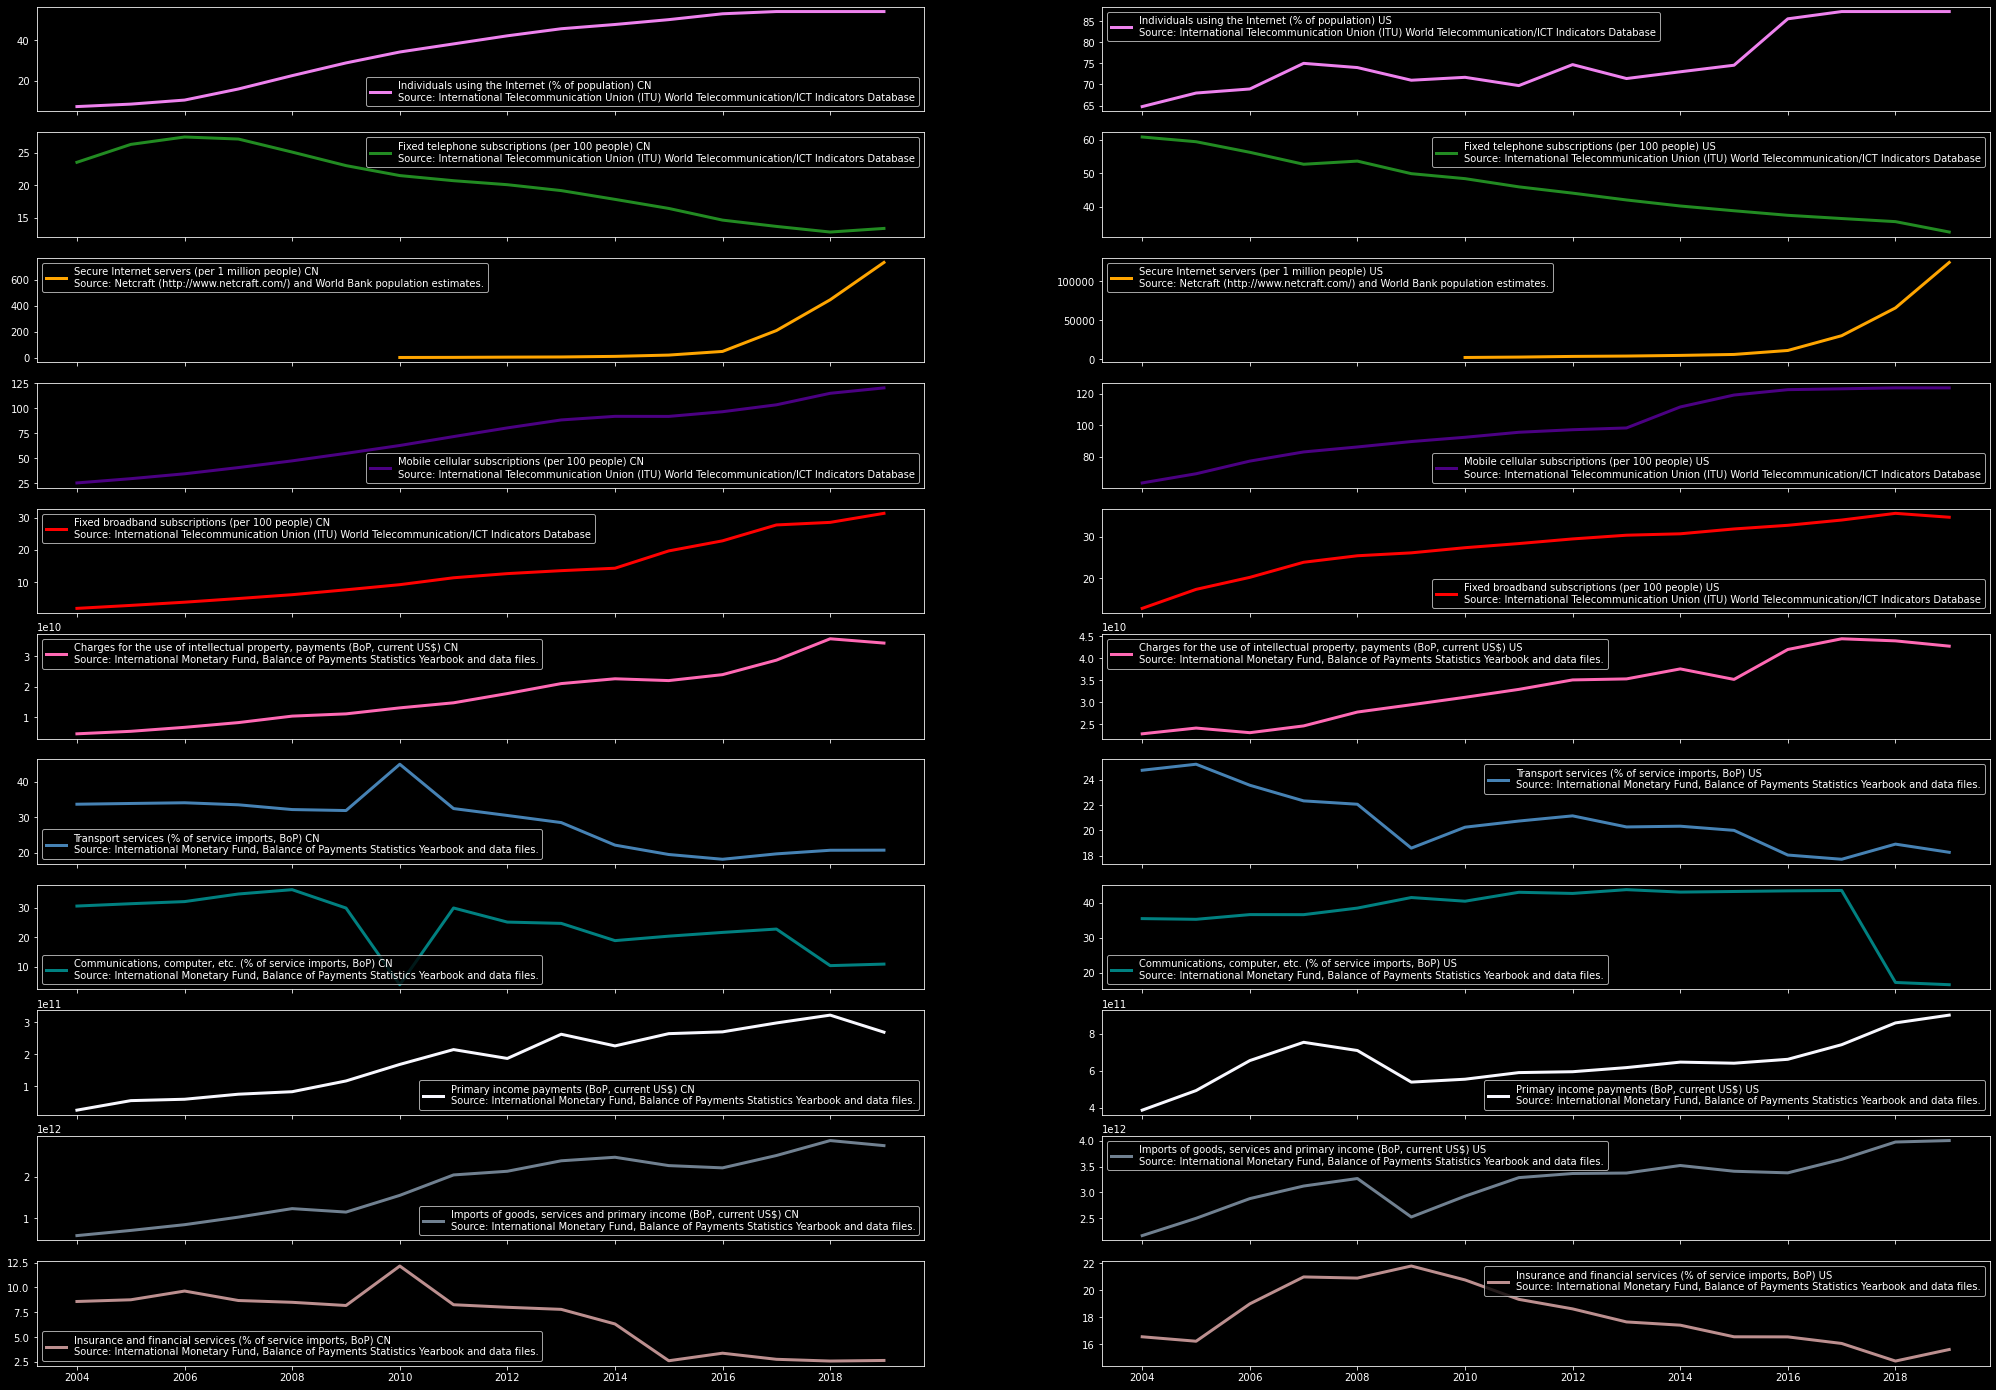

In [161]:
plt.style.use('dark_background')
fig, ax = plt.subplots(n, ncols = 2, figsize = (35, 25), sharex = True)
for i in range(n * 2):
    row, col = i % n, i // n
    col_name = [*world_bank_dfs[col].columns][row]
    country = col_name[-2:]
    col_name = col_name[:-3]
    label = wb_plot_map[col_name] + " " + country.upper() + "\nSource: "
    label += source_map[col_name]
    ax[row, col].plot(world_bank_dfs[col].index, 
                    world_bank_dfs[col].iloc[:, row], 
        color = plt_colors[row], 
        #label = [[world_bank_dfs[col].columns][row]], 
        label = label, 
        lw = 3)
    if row == ax.shape[0]:
        ax[row, col].set_xlabel('Year')
    ax[row, col].legend()
plt.show(fig); 

# * a digression toward something that's striking *
 the proportion of American individuals using internet in 2007 was 3 / 4.
 That proportion wasn't exceeded for 9 years and in fact went down
 4 of those 9 years. the ~+11% jump happened over the course of the same
 year that the maximum breach happened, 2015. maybe they're symptoms of the same
 thing. maybe they're not. that hypothesis isn't tested here though

In [122]:
digression = inet_data_us[['pct_pop_using_inet_us']][::-1]
digression['diff'] = digression.diff()
digression.dropna(inplace = True)
digression

,pct_pop_using_inet_us,diff
date,,
2005-01-01,67.9681,3.2098
2006-01-01,68.9312,0.9631
2007-01-01,75.0000,6.0688
2008-01-01,74.0000,-1.0000
2009-01-01,71.0000,-3.0000
2010-01-01,71.6900,0.6900
2011-01-01,69.7295,-1.9605
2012-01-01,74.7000,4.9705
2013-01-01,71.4000,-3.3000


In [123]:
# column_name -> # of NA years (rows) given year >= 2009  
cn_shift_map = dict(inet_data_cn[inet_data_cn.index >= '2009-01-01'].isna().sum().items())
us_shift_map = dict(inet_data_us[inet_data_us.index >= '2009-01-02'].isna().sum().items())

In [124]:
def getUpsampled(shift_map, inet_data_grouped) -> pd.DataFrame: 
    # shift_map: column_name -> # of rows to shift forward in time 
    # inet_data_grouped: dataframe of specific country's fields
    f = lambda k: inet_data_grouped[k].shift(-shift_map[k])
    upsampled_map = dict(zip(shift_map.keys(), map(f, shift_map.keys())))
    # adds a country indicator to facilitate binding rows of each inet_data_grouped frame  
    upsampled_map['cn'] = 1 if 'cn' in [*shift_map.keys()][0] else 0
    # country-specific column name -> standard column name. includes new cn indicator  
    return pd.DataFrame(upsampled_map)

In [125]:
def getInterpolatedDF(df, rule = 'D', method = 'cubic') -> pd.DataFrame:
    """return df with interpolation of resampled df according to rule and method"""
    return df.resample(rule).asfreq().interpolate(method).drop(columns = 'cn')

In [126]:
u = dict(getInterpolatedDF(getUpsampled(us_shift_map, inet_data_us)).bfill())
u.update(getInterpolatedDF(getUpsampled(cn_shift_map, inet_data_cn)).bfill())
# u

## adds components for dates up to and including the most recent breach_submission_date
## in internet_data::

In [127]:
wb_inet_filled = pd.DataFrame(u)
inet_df_recent_map = dict(columns = dict().fromkeys(wb_inet_filled.columns), 
            index = pd.date_range(wb_inet_filled.index.max(), 
            data.breach_submission_date.max()))
internet_data = pd.concat([wb_inet_filled, pd.DataFrame(**inet_df_recent_map)]).ffill()
internet_data.index.name = 'breach_submission_date'
internet_data.reset_index(inplace = True)
internet_data

,breach_submission_date,pct_pop_using_inet_us,fixed_phone_subs_per_100_us,secure_servers_per_mil_us,mobile_cell_subs_per_100_us,fixed_bbnd_subs_per_100_us,ip_payments_us,transpt_pct_serv_imports_us,comm_pct_serv_imports_us,prim_income_pmts_us,...,fixed_phone_subs_per_100_cn,secure_servers_per_mil_cn,mobile_cell_subs_per_100_cn,fixed_bbnd_subs_per_100_cn,ip_payments_cn,transpt_pct_serv_imports_cn,comm_pct_serv_imports_cn,prim_income_pmts_cn,igs_primary_income_cn,insfin_pct_serv_imports_cn
0,2004-01-01,64.7583,60.7792,2481.759554,63.2174,12.7764,2.281800e+10,24.760070,35.462914,3.862570e+11,...,23.5628,1.199069,25.3063,1.88496,4.496605e+09,33.676663,30.649828,2.568907e+10,5.792894e+11,8.591681
1,2004-01-02,64.7583,60.7792,2481.759554,63.2174,12.7764,2.281800e+10,24.760070,35.462914,3.862570e+11,...,23.5628,1.199069,25.3063,1.88496,4.496605e+09,33.676663,30.649828,2.568907e+10,5.792894e+11,8.591681
2,2004-01-03,64.7583,60.7792,2481.759554,63.2174,12.7764,2.281800e+10,24.760070,35.462914,3.862570e+11,...,23.5628,1.199069,25.3063,1.88496,4.496605e+09,33.676663,30.649828,2.568907e+10,5.792894e+11,8.591681
3,2004-01-04,64.7583,60.7792,2481.759554,63.2174,12.7764,2.281800e+10,24.760070,35.462914,3.862570e+11,...,23.5628,1.199069,25.3063,1.88496,4.496605e+09,33.676663,30.649828,2.568907e+10,5.792894e+11,8.591681
4,2004-01-05,64.7583,60.7792,2481.759554,63.2174,12.7764,2.281800e+10,24.760070,35.462914,3.862570e+11,...,23.5628,1.199069,25.3063,1.88496,4.496605e+09,33.676663,30.649828,2.568907e+10,5.792894e+11,8.591681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6205,2020-12-26,87.2661,32.6018,124014.176075,123.6880,34.6719,4.273200e+10,18.264405,16.504267,8.993470e+11,...,13.3237,446.706828,120.3600,31.33520,3.437047e+10,20.801686,10.990667,2.688465e+11,2.748101e+12,2.655133
6206,2020-12-27,87.2661,32.6018,124014.176075,123.6880,34.6719,4.273200e+10,18.264405,16.504267,8.993470e+11,...,13.3237,446.706828,120.3600,31.33520,3.437047e+10,20.801686,10.990667,2.688465e+11,2.748101e+12,2.655133
6207,2020-12-28,87.2661,32.6018,124014.176075,123.6880,34.6719,4.273200e+10,18.264405,16.504267,8.993470e+11,...,13.3237,446.706828,120.3600,31.33520,3.437047e+10,20.801686,10.990667,2.688465e+11,2.748101e+12,2.655133
6208,2020-12-29,87.2661,32.6018,124014.176075,123.6880,34.6719,4.273200e+10,18.264405,16.504267,8.993470e+11,...,13.3237,446.706828,120.3600,31.33520,3.437047e+10,20.801686,10.990667,2.688465e+11,2.748101e+12,2.655133


In [128]:
data2 = pd.merge(internet_data, data, how = 'outer')
data2.index = pd.MultiIndex.from_tuples(tuple(zip(data2.breach_id, data2.state)), 
                names = ['breach_id', 'state'])
data2 = data2[data2.breach_id.notna()]
data2.sort_values(by = 'breach_submission_date')
data2

,,breach_submission_date,pct_pop_using_inet_us,fixed_phone_subs_per_100_us,secure_servers_per_mil_us,mobile_cell_subs_per_100_us,fixed_bbnd_subs_per_100_us,ip_payments_us,transpt_pct_serv_imports_us,comm_pct_serv_imports_us,prim_income_pmts_us,...,lobi_paper,tob_theft,tob_loss,tob_unknown,tob_improper_disposal,tob_hacking,tob_unauthorized_access,log1p_ia_gt50,log1p_ia_gtmean,web_description_present
breach_id,state,,,,,,,,,,,,,,,,,,,,,
2811.0,TX,2009-10-21,71.239127,50.661065,2481.759554,88.898027,25.943095,2.914372e+10,19.022022,41.251780,5.622730e+11,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2810.0,MO,2009-10-28,71.203307,50.579659,2481.759554,88.963380,25.958200,2.916989e+10,18.965886,41.290011,5.594085e+11,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2809.0,AK,2009-10-30,71.193529,50.556654,2481.759554,88.981970,25.962571,2.917739e+10,18.950353,41.300455,5.586065e+11,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2808.0,DC,2009-11-17,71.115000,50.355294,2481.759554,89.147502,26.003097,2.924528e+10,18.821331,41.384467,5.517368e+11,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2805.0,CA,2009-11-20,71.103622,50.322820,2481.759554,89.174762,26.010067,2.925670e+10,18.801809,41.396656,5.506558e+11,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3546.0,CT,2020-12-22,87.266100,32.601800,124014.176075,123.688000,34.671900,4.273200e+10,18.264405,16.504267,8.993470e+11,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
3545.0,AR,2020-12-22,87.266100,32.601800,124014.176075,123.688000,34.671900,4.273200e+10,18.264405,16.504267,8.993470e+11,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3577.0,IN,2020-12-23,87.266100,32.601800,124014.176075,123.688000,34.671900,4.273200e+10,18.264405,16.504267,8.993470e+11,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


,,breach_submission_date,pct_pop_using_inet_us,fixed_phone_subs_per_100_us,secure_servers_per_mil_us,mobile_cell_subs_per_100_us,fixed_bbnd_subs_per_100_us,ip_payments_us,transpt_pct_serv_imports_us,comm_pct_serv_imports_us,prim_income_pmts_us,...,lobi_paper,tob_theft,tob_loss,tob_unknown,tob_improper_disposal,tob_hacking,tob_unauthorized_access,log1p_ia_gt50,log1p_ia_gtmean,web_description_present
breach_id,state,,,,,,,,,,,,,,,,,,,,,
2811.0,TX,2009-10-21,71.239127,50.661065,2481.759554,88.898027,25.943095,2.914372e+10,19.022022,41.251780,5.622730e+11,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2810.0,MO,2009-10-28,71.203307,50.579659,2481.759554,88.963380,25.958200,2.916989e+10,18.965886,41.290011,5.594085e+11,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2809.0,AK,2009-10-30,71.193529,50.556654,2481.759554,88.981970,25.962571,2.917739e+10,18.950353,41.300455,5.586065e+11,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2808.0,DC,2009-11-17,71.115000,50.355294,2481.759554,89.147502,26.003097,2.924528e+10,18.821331,41.384467,5.517368e+11,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2805.0,CA,2009-11-20,71.103622,50.322820,2481.759554,89.174762,26.010067,2.925670e+10,18.801809,41.396656,5.506558e+11,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3545.0,AR,2020-12-22,87.266100,32.601800,124014.176075,123.688000,34.671900,4.273200e+10,18.264405,16.504267,8.993470e+11,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3546.0,CT,2020-12-22,87.266100,32.601800,124014.176075,123.688000,34.671900,4.273200e+10,18.264405,16.504267,8.993470e+11,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
3577.0,IN,2020-12-23,87.266100,32.601800,124014.176075,123.688000,34.671900,4.273200e+10,18.264405,16.504267,8.993470e+11,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [129]:
dict(data2.isna().sum())
data2.columns.tolist()

{'breach_submission_date': 0,
 'pct_pop_using_inet_us': 0,
 'fixed_phone_subs_per_100_us': 0,
 'secure_servers_per_mil_us': 0,
 'mobile_cell_subs_per_100_us': 0,
 'fixed_bbnd_subs_per_100_us': 0,
 'ip_payments_us': 0,
 'transpt_pct_serv_imports_us': 0,
 'comm_pct_serv_imports_us': 0,
 'prim_income_pmts_us': 0,
 'igs_primary_income_us': 0,
 'insfin_pct_serv_imports_us': 0,
 'pct_pop_using_inet_cn': 0,
 'fixed_phone_subs_per_100_cn': 0,
 'secure_servers_per_mil_cn': 0,
 'mobile_cell_subs_per_100_cn': 0,
 'fixed_bbnd_subs_per_100_cn': 0,
 'ip_payments_cn': 0,
 'transpt_pct_serv_imports_cn': 0,
 'comm_pct_serv_imports_cn': 0,
 'prim_income_pmts_cn': 0,
 'igs_primary_income_cn': 0,
 'insfin_pct_serv_imports_cn': 0,
 'breach_id': 0,
 'name_of_covered_entity': 0,
 'state': 10,
 'covered_entity_type': 3,
 'individuals_affected': 0,
 'type_of_breach': 1,
 'location_of_breached_information': 0,
 'web_description': 0,
 'business_associate_present': 0,
 'lobi_network_server': 0,
 'lobi_unknown': 0

['breach_submission_date',
 'pct_pop_using_inet_us',
 'fixed_phone_subs_per_100_us',
 'secure_servers_per_mil_us',
 'mobile_cell_subs_per_100_us',
 'fixed_bbnd_subs_per_100_us',
 'ip_payments_us',
 'transpt_pct_serv_imports_us',
 'comm_pct_serv_imports_us',
 'prim_income_pmts_us',
 'igs_primary_income_us',
 'insfin_pct_serv_imports_us',
 'pct_pop_using_inet_cn',
 'fixed_phone_subs_per_100_cn',
 'secure_servers_per_mil_cn',
 'mobile_cell_subs_per_100_cn',
 'fixed_bbnd_subs_per_100_cn',
 'ip_payments_cn',
 'transpt_pct_serv_imports_cn',
 'comm_pct_serv_imports_cn',
 'prim_income_pmts_cn',
 'igs_primary_income_cn',
 'insfin_pct_serv_imports_cn',
 'breach_id',
 'name_of_covered_entity',
 'state',
 'covered_entity_type',
 'individuals_affected',
 'type_of_breach',
 'location_of_breached_information',
 'web_description',
 'business_associate_present',
 'lobi_network_server',
 'lobi_unknown',
 'lobi_email',
 'lobi_desktop_computer',
 'lobi_laptop',
 'lobi_other_portable_electronic_device',
 '

 *** integrate os market share stats: Retrieving additional explanatory variables from https://gs.statcounter.com/ ***
 # stat counter json files included in this repo have the links  

In [130]:
import json

In [131]:
def get_links(file) -> dict:
    with open(file) as infile:
        return json.load(infile)

In [132]:
def df_from_links(links_map, index_col = 'Date') -> dict:
    '''returns a dataframe from url using pd.read_csv. 
    dataframes aren't concatenated to keep column names identifiable'''    
    f = lambda csv_url: pd.read_csv(links_map[csv_url], index_col = index_col)
    return dict(zip(links_map.keys(), map(f, links_map.keys())))

In [133]:
search_data = df_from_links(get_links('stat_counter_search.json'))
#search_data 

In [134]:
sm_data = df_from_links(get_links('stat_counter_soc_med.json'))
#sm_data

In [135]:
def make_col_names_specific(df, suffix = '_ww') -> pd.DataFrame:
    """appends identifying suffix (_ww or _us) to all column names of df and 
    replaces all whitespace with underscore"""
    col_names = [*df.columns]
    specific_names = [*df.columns + suffix]
    specific_names = list(map(lambda name: name.replace(' ', '_'), specific_names))
    return df.rename(columns = dict(zip(col_names, specific_names)))

In [136]:
def combineRegions(df1, df2, suffix1, suffix2) -> pd.DataFrame:
    """make column names of df1 and df2 specific and return a dataframe 
    that combines the two distinct dataframes"""
    df1_new = make_col_names_specific(df1, suffix1)
    df2_new = make_col_names_specific(df2, suffix2)
    combined = pd.concat((df1_new, df2_new), axis = 1) 
    return combined.set_index(pd.to_datetime(combined.index))

In [137]:
search_df_map = dict(df1 = search_data['search_ww'], df2 = search_data['search_us'], 
                    suffix1 = '_ww', suffix2 = '_us')
search_df = combineRegions(**search_df_map)
search_df = search_df.resample('D').asfreq().interpolate(method = 'cubic')
search_df

,Google_ww,bing_ww,Yahoo!_ww,Baidu_ww,YANDEX_RU_ww,Ask_Jeeves_ww,YANDEX_ww,Naver_ww,AOL_ww,DuckDuckGo_ww,...,Windows_Live_us,Baidu_us,AVG_Search_us,Comcast_us,Babylon_us,Dogpile_us,Earthlink_us,Norton_Safe_Search_us,YANDEX_RU_us,Other_us
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,90.250000,0.000000,5.910000,0.000000,0.160000,4.000000e-01,0.000000e+00,0.000000,4.800000e-01,0.000000e+00,...,1.830000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e-02,0.000000e+00,0.000000e+00,0.120000
2009-01-02,90.261770,0.005041,5.874335,-0.011698,0.162766,3.971620e-01,1.036460e-26,0.000850,4.745821e-01,9.644920e-28,...,1.993489e+00,0.000001,3.291549e-16,6.771837e-34,3.293803e-25,2.090269e-34,7.893187e-02,1.503139e-34,-2.941622e-23,0.120106
2009-01-03,90.270584,0.009577,5.841433,-0.022353,0.165375,3.945579e-01,1.969274e-26,0.001653,4.696004e-01,1.832535e-27,...,2.150350e+00,0.000002,6.253944e-16,1.286649e-33,6.258225e-25,3.971510e-34,7.793283e-02,2.855965e-34,-5.589082e-23,0.120164
2009-01-04,90.276541,0.013627,5.811214,-0.031993,0.167831,3.921810e-01,2.802016e-26,0.002409,4.650424e-01,2.607454e-27,...,2.300707e+00,0.000003,8.898533e-16,1.830731e-33,8.904625e-25,5.650933e-34,7.700087e-02,4.063660e-34,-7.952523e-23,0.120176
2009-01-05,90.279741,0.017208,5.783602,-0.040644,0.170136,3.900244e-01,3.538260e-26,0.003121,4.608962e-01,3.292576e-27,...,2.444683e+00,0.000004,1.123667e-15,2.311765e-33,1.124436e-24,7.135744e-34,7.613399e-02,5.131407e-34,-1.004209e-22,0.120143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-28,92.338568,2.829926,1.496844,1.106050,0.432946,3.682526e-07,4.900430e-01,0.124117,3.875317e-22,5.833452e-01,...,3.001214e-63,0.045373,-3.524767e-34,-1.184065e-39,3.543837e-46,1.768772e-02,1.725170e-25,2.000000e-02,3.000000e-02,0.166945
2020-10-29,92.297600,2.841369,1.502068,1.113547,0.432262,2.914435e-07,4.948905e-01,0.125376,3.067015e-22,5.896478e-01,...,2.375230e-63,0.046461,-2.789581e-34,-9.370967e-40,2.804674e-46,1.823125e-02,1.365340e-25,2.000000e-02,3.000000e-02,0.167643
2020-10-30,92.254216,2.853519,1.507665,1.121692,0.431544,2.047044e-07,4.998350e-01,0.126774,2.154213e-22,5.961886e-01,...,1.668316e-63,0.047594,-1.959349e-34,-6.581988e-40,1.969950e-46,1.879751e-02,9.589885e-26,2.000000e-02,3.000000e-02,0.168384


In [138]:
search_df_recent_map = dict(columns = dict().fromkeys(search_df.columns), 
            index = pd.date_range(search_df.index.max(), 
            data.breach_submission_date.max()))
search_df_recent_map

{'columns': {'Google_ww': None,
  'bing_ww': None,
  'Yahoo!_ww': None,
  'Baidu_ww': None,
  'YANDEX_RU_ww': None,
  'Ask_Jeeves_ww': None,
  'YANDEX_ww': None,
  'Naver_ww': None,
  'AOL_ww': None,
  'DuckDuckGo_ww': None,
  'Haosou_ww': None,
  'Babylon_ww': None,
  'Sogou_ww': None,
  'Shenma_ww': None,
  'Conduit_ww': None,
  'Seznam_ww': None,
  'MSN_ww': None,
  'Mail.ru_ww': None,
  'Webcrawler_ww': None,
  'StartPagina_(Google)_ww': None,
  'AVG_Search_ww': None,
  'Daum_ww': None,
  'SweetIM_ww': None,
  'Windows_Live_ww': None,
  'Other_ww': None,
  'Google_us': None,
  'bing_us': None,
  'Yahoo!_us': None,
  'AOL_us': None,
  'Ask_Jeeves_us': None,
  'DuckDuckGo_us': None,
  'MSN_us': None,
  'Webcrawler_us': None,
  'Windows_Live_us': None,
  'Baidu_us': None,
  'AVG_Search_us': None,
  'Comcast_us': None,
  'Babylon_us': None,
  'Dogpile_us': None,
  'Earthlink_us': None,
  'Norton_Safe_Search_us': None,
  'YANDEX_RU_us': None,
  'Other_us': None},
 'index': DatetimeIndex

In [139]:
search_df = pd.concat((search_df, pd.DataFrame(**search_df_recent_map))).ffill()
search_df.index.name = 'breach_submission_date'
search_df.reset_index(inplace = True)
search_df.sample(10)

,breach_submission_date,Google_ww,bing_ww,Yahoo!_ww,Baidu_ww,YANDEX_RU_ww,Ask_Jeeves_ww,YANDEX_ww,Naver_ww,AOL_ww,...,Windows_Live_us,Baidu_us,AVG_Search_us,Comcast_us,Babylon_us,Dogpile_us,Earthlink_us,Norton_Safe_Search_us,YANDEX_RU_us,Other_us
3666,2019-01-15,93.010800,2.387242,1.774871,0.950845,0.568121,0.010005,0.285254,0.096139,-1.527133e-10,...,-1.182679e-51,0.039997,1.388993e-22,4.666009e-28,-1.396508e-34,-1.078845e-03,-6.798323e-14,3.007038e-02,0.018696,0.034191
1122,2012-01-28,92.162004,3.261398,3.205006,0.236951,0.347806,0.321847,0.000003,0.031651,1.814474e-01,...,-3.247471e-04,0.010000,1.990535e-02,2.069686e-13,1.006689e-04,6.388517e-14,2.087630e-02,4.594066e-14,0.010254,0.041088
1110,2012-01-16,92.071864,3.306870,3.205978,0.221368,0.343785,0.326742,0.000005,0.086415,1.852176e-01,...,-1.302701e-03,0.010000,1.786476e-02,3.159433e-13,1.536739e-04,9.752247e-14,2.480397e-02,7.012968e-14,0.011018,0.045303
3473,2018-07-06,90.482039,3.160122,2.250704,1.885286,0.603940,0.010000,0.230285,0.156510,-3.004541e-07,...,-2.326847e-48,0.067238,2.732759e-19,9.180085e-25,-2.747544e-31,-3.843159e-04,-1.337528e-10,2.998528e-02,0.082029,0.048733
4014,2019-12-29,92.540315,2.443623,1.637091,1.081927,0.541035,-0.000622,0.386504,0.081328,1.403477e-17,...,1.086914e-58,0.030600,-1.276523e-29,-4.288188e-35,1.283429e-41,1.000000e-02,6.247843e-21,2.000002e-02,0.029926,0.159913
3999,2019-12-14,92.633038,2.384589,1.610707,1.067503,0.551249,-0.000881,0.440860,0.096684,8.006526e-17,...,6.200602e-58,0.036499,-7.282279e-29,-2.446317e-34,7.321679e-41,9.999994e-03,3.564256e-20,2.000011e-02,0.031485,0.163320
2570,2016-01-15,91.007153,3.161668,2.986185,0.944022,0.354198,0.175054,0.370019,0.217527,1.252726e-01,...,-4.660289e-31,0.038841,9.747496e-03,1.838619e-07,-5.502876e-14,4.993236e-02,1.000001e-02,4.052072e-02,0.009994,0.044591
3500,2018-08-02,90.945512,3.162507,2.466171,1.348068,0.580248,0.010000,0.231574,0.150817,2.054571e-08,...,1.591149e-49,0.049434,-1.868720e-20,-6.277543e-26,1.878831e-32,2.636221e-05,9.146310e-12,3.000100e-02,0.018578,0.039807
2601,2016-02-15,91.412183,2.955690,2.858592,1.023973,0.376554,0.164940,0.352515,0.119732,1.140085e-01,...,1.117278e-31,0.045983,1.090153e-02,-4.407984e-08,1.319283e-14,5.001505e-02,9.999998e-03,3.700542e-02,0.010023,0.042713
4327,2020-11-05,92.160000,2.880000,1.520000,1.140000,0.430000,0.000000,0.510000,0.130000,0.000000e+00,...,0.000000e+00,0.050000,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e-02,0.000000e+00,2.000000e-02,0.030000,0.170000


In [140]:
data3 = pd.merge(data2, search_df, how = 'outer', on = 'breach_submission_date')
data3.index = pd.MultiIndex.from_tuples(tuple(zip(data3.breach_id, data3.state)), 
                names = [*data2.index.names])
data3 = data3[data3.breach_id.notna()]
#data3.sort_values(by = 'breach_submission_date')
data3.sample(10)

,,breach_submission_date,pct_pop_using_inet_us,fixed_phone_subs_per_100_us,secure_servers_per_mil_us,mobile_cell_subs_per_100_us,fixed_bbnd_subs_per_100_us,ip_payments_us,transpt_pct_serv_imports_us,comm_pct_serv_imports_us,prim_income_pmts_us,...,Windows_Live_us,Baidu_us,AVG_Search_us,Comcast_us,Babylon_us,Dogpile_us,Earthlink_us,Norton_Safe_Search_us,YANDEX_RU_us,Other_us
breach_id,state,,,,,,,,,,,,,,,,,,,,,
2639.0,IN,2011-01-12,71.642266,48.381558,2480.259057,92.355468,27.387597,3.116473e+10,20.306088,40.477901,5.550525e+11,...,7.146160e-09,0.010000,1.897914e-02,3.353149e-20,1.630962e-11,1.035019e-20,2.999454e-02,7.442958e-21,-1.456576e-09,0.039839
2154.0,MI,2013-10-23,71.977276,42.502539,4206.590645,97.080085,30.242044,3.504564e+10,20.427761,43.616830,6.098426e+11,...,7.769353e-16,0.032436,9.064633e-02,2.532056e-01,3.351919e-02,7.450816e-02,1.258083e-02,5.271460e-02,1.000000e-02,0.199311
1161.0,PA,2017-09-15,87.506354,36.839899,23115.895846,123.059520,33.534927,4.427099e+10,17.569939,45.827195,7.099913e+11,...,-1.606195e-42,0.070902,1.886391e-13,6.336905e-19,-1.896598e-25,3.000123e-02,-9.232800e-05,2.099419e-02,2.034544e-02,0.053935
2918.0,NC,2020-02-03,87.266100,32.601800,124014.176075,123.688000,34.671900,4.273200e+10,18.264405,16.504267,8.993470e+11,...,1.459564e-59,0.041207,-1.714180e-30,-5.758401e-36,1.723455e-42,1.000001e-02,8.389926e-22,2.000000e-02,2.998888e-02,0.170532
3383.0,NaN,2019-04-13,87.367336,35.153500,79511.724977,123.824059,35.754171,4.364146e+10,19.087153,11.145222,8.825402e+11,...,2.244675e-53,0.040004,-2.636252e-24,-8.855893e-30,2.650516e-36,9.683949e-03,1.290294e-15,2.617477e-02,1.913710e-02,0.028915
520.0,MI,2011-10-28,69.577471,46.447818,2836.305448,94.891168,28.172000,3.251996e+10,20.713282,42.636072,5.859288e+11,...,-8.462467e-04,0.010000,1.453629e-01,-3.974682e-15,-1.933274e-06,-1.226868e-15,2.035224e-02,-8.822570e-16,1.726564e-04,0.051023
1714.0,OR,2015-08-21,73.121376,39.406658,5811.360745,117.228943,31.400791,3.551835e+10,20.330483,43.256579,6.428278e+11,...,2.464064e-28,0.060558,9.996424e-03,-9.721444e-05,2.909570e-11,5.545746e-02,9.994815e-03,4.209603e-02,1.000001e-02,0.046782
494.0,MD,2012-06-04,71.861504,45.128308,3376.701641,96.574566,28.797573,3.400347e+10,20.964974,43.083433,5.919263e+11,...,8.933145e-07,0.010050,1.001289e-02,-4.358282e-11,1.233090e-01,-1.345274e-11,1.999765e-02,-9.674044e-12,9.999302e-03,0.069708
1623.0,IA,2016-02-02,75.257569,38.786782,6523.322250,119.546609,31.948162,3.542311e+10,19.868656,43.170487,6.396026e+11,...,2.233058e-32,0.040305,1.005786e-02,-8.810060e-09,2.636798e-15,5.000318e-02,1.000000e-02,3.987970e-02,1.000145e-02,0.039984


# ***Integrate social media percentage mkt share stats from https://gs.statcounter.com/social-media-stats#***

In [141]:
soc_med_df_map = dict(df1 = sm_data['soc_media_us'], df2 = sm_data['soc_media_ww'], 
                    suffix1 = '_us', suffix2 = '_ww')
soc_med_df = combineRegions(**soc_med_df_map)
soc_med_df = soc_med_df.resample('D').asfreq().interpolate(method = 'cubic')
# drops any rows that are assigned a zero vector 
soc_med_df.drop(index = [*soc_med_df[soc_med_df.sum(axis = 1) == 0].index], inplace = True)
soc_med_df.sample(5)

,Facebook_us,Pinterest_us,StumbleUpon_us,Twitter_us,reddit_us,Tumblr_us,YouTube_us,Instagram_us,Digg_us,LinkedIn_us,...,MySpace_ww,Fark_ww,NowPublic_ww,iWiW_ww,news.ycombinator.com_ww,Delicious_ww,orkut_ww,Odnoklassniki_ww,Vimeo_ww,Other_ww
Date,,,,,,,,,,,,,,,,,,,,,
2011-02-07,45.946165,1.306980e-07,37.243021,5.510517,4.594068,1.463745e-19,4.408685,-1.347223e-41,0.720470,0.252176,...,7.626973e-02,0.225722,2.797676e-01,1.913476e-02,0.067254,1.405186e-01,9.242920e-02,-3.158606e-05,2.873014e-02,0.338306
2015-11-10,68.972749,1.894959e+01,1.491899,5.294273,2.342020,2.402569e+00,0.141772,8.481022e-09,0.009843,0.065980,...,-1.273599e-03,0.010100,-1.379158e-16,-3.307076e-16,0.013361,-1.423993e-11,5.178672e-18,-7.099969e-10,-3.020527e-08,0.009420
2018-01-07,77.579583,1.456816e+01,0.358798,3.926465,0.558937,6.197835e-01,0.948284,1.145050e+00,-0.000337,0.113178,...,-1.452394e-18,0.030101,-1.572772e-31,-3.771341e-31,0.009311,-1.623901e-26,5.905683e-33,-8.096701e-25,-1.942769e-07,0.045878
2015-05-03,73.111391,1.513706e+01,1.728743,4.752930,2.201293,2.571503e+00,0.060123,6.005654e-13,0.020007,0.049343,...,3.011836e-06,0.010157,-1.368734e-13,-3.282080e-13,0.019268,-1.413230e-08,5.139530e-15,-7.046304e-07,-3.000681e-05,-0.000007
2017-12-15,76.106206,1.566779e+01,0.335597,4.129585,0.636358,6.301325e-01,1.036332,1.061355e+00,-0.000743,0.132306,...,6.742735e-18,0.019738,7.301589e-31,1.750844e-30,0.010740,7.538956e-26,-2.741712e-32,3.758892e-24,1.293716e-07,0.047834


In [142]:
soc_med_df_recent_map = dict(columns = dict().fromkeys(soc_med_df.columns), 
                        index = pd.date_range(data2.breach_submission_date.min(),
                        data2.breach_submission_date.max()))
soc_med_df_recent_map

{'columns': {'Facebook_us': None,
  'Pinterest_us': None,
  'StumbleUpon_us': None,
  'Twitter_us': None,
  'reddit_us': None,
  'Tumblr_us': None,
  'YouTube_us': None,
  'Instagram_us': None,
  'Digg_us': None,
  'LinkedIn_us': None,
  'MySpace_us': None,
  'Fark_us': None,
  'Google+_us': None,
  'NowPublic_us': None,
  'news.ycombinator.com_us': None,
  'Delicious_us': None,
  'VKontakte_us': None,
  'Vimeo_us': None,
  'Other_us': None,
  'Facebook_ww': None,
  'Pinterest_ww': None,
  'Twitter_ww': None,
  'StumbleUpon_ww': None,
  'YouTube_ww': None,
  'Tumblr_ww': None,
  'reddit_ww': None,
  'Instagram_ww': None,
  'VKontakte_ww': None,
  'Google+_ww': None,
  'LinkedIn_ww': None,
  'Digg_ww': None,
  'MySpace_ww': None,
  'Fark_ww': None,
  'NowPublic_ww': None,
  'iWiW_ww': None,
  'news.ycombinator.com_ww': None,
  'Delicious_ww': None,
  'orkut_ww': None,
  'Odnoklassniki_ww': None,
  'Vimeo_ww': None,
  'Other_ww': None},
 'index': DatetimeIndex(['2009-10-21', '2009-10-22'

In [143]:
soc_med_df = pd.concat((soc_med_df, pd.DataFrame(**soc_med_df_recent_map)), axis = 0).ffill()
soc_med_df.index.name = 'breach_submission_date'
soc_med_df.reset_index(inplace = True)
soc_med_df.dropna(inplace = True)
soc_med_df.info()
soc_med_df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8321 entries, 0 to 8320
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   breach_submission_date   8321 non-null   datetime64[ns]
 1   Facebook_us              8321 non-null   float64       
 2   Pinterest_us             8321 non-null   float64       
 3   StumbleUpon_us           8321 non-null   float64       
 4   Twitter_us               8321 non-null   float64       
 5   reddit_us                8321 non-null   float64       
 6   Tumblr_us                8321 non-null   float64       
 7   YouTube_us               8321 non-null   float64       
 8   Instagram_us             8321 non-null   float64       
 9   Digg_us                  8321 non-null   float64       
 10  LinkedIn_us              8321 non-null   float64       
 11  MySpace_us               8321 non-null   float64       
 12  Fark_us                  8321 non-

,breach_submission_date,Facebook_us,Pinterest_us,StumbleUpon_us,Twitter_us,reddit_us,Tumblr_us,YouTube_us,Instagram_us,Digg_us,...,MySpace_ww,Fark_ww,NowPublic_ww,iWiW_ww,news.ycombinator.com_ww,Delicious_ww,orkut_ww,Odnoklassniki_ww,Vimeo_ww,Other_ww
0,2009-03-02,0.667408,-1.808766e-20,2.463151,0.254222,0.780180,-2.025717e-32,0.000853,1.864459e-54,0.292291,...,1.169852,0.010703,0.002148,-0.061717,0.002521,0.026609,0.101038,4.371283e-18,0.000005,0.162425
1,2009-03-03,1.314945,-3.438665e-20,4.839785,0.506078,1.519977,-3.851114e-32,0.001622,3.544544e-54,0.577521,...,2.281927,0.021046,0.004226,-0.117215,0.005068,0.052357,0.198550,8.310294e-18,0.000010,0.319321
2,2009-03-04,1.942932,-4.895727e-20,7.131308,0.755550,2.220374,-5.482941e-32,0.002309,5.046469e-54,0.855742,...,3.337431,0.031041,0.006236,-0.166645,0.007638,0.077260,0.292595,1.183161e-17,0.000014,0.470768
3,2009-03-05,2.551689,-6.185980e-20,9.339128,1.002615,2.882356,-6.927953e-32,0.002918,6.376450e-54,1.127010,...,4.337566,0.040700,0.008179,-0.210161,0.010229,0.101332,0.383229,1.494979e-17,0.000018,0.616849
4,2009-03-06,3.141537,-7.315454e-20,11.464651,1.247255,3.506907,-8.192901e-32,0.003451,7.540701e-54,1.391378,...,5.283537,0.050036,0.010056,-0.247917,0.012840,0.124587,0.470510,1.767941e-17,0.000021,0.757644


In [144]:
xy_df = pd.merge(data3, soc_med_df, how = 'outer', on = 'breach_submission_date')
xy_df.index = pd.MultiIndex.from_tuples(tuple(zip(xy_df.breach_id, xy_df.state)), 
                names = [*data3.index.names])
xy_df = xy_df[xy_df.breach_id.notna()]
xy_df.drop_duplicates(subset = ['breach_id'], inplace = True)
xy_df.sort_values(by = 'breach_submission_date', inplace = True)
xy_df.sample(5)
xy_df.info()

,,breach_submission_date,pct_pop_using_inet_us,fixed_phone_subs_per_100_us,secure_servers_per_mil_us,mobile_cell_subs_per_100_us,fixed_bbnd_subs_per_100_us,ip_payments_us,transpt_pct_serv_imports_us,comm_pct_serv_imports_us,prim_income_pmts_us,...,MySpace_ww,Fark_ww,NowPublic_ww,iWiW_ww,news.ycombinator.com_ww,Delicious_ww,orkut_ww,Odnoklassniki_ww,Vimeo_ww,Other_ww_y
breach_id,state,,,,,,,,,,,,,,,,,,,,,
89.0,TX,2019-01-03,87.268253,35.676289,66114.249355,123.691232,35.611364,4.392680e+10,18.917889,17.005161,8.578584e+11,...,-8.526396e-26,0.009957,-9.233084e-39,-2.213996e-38,0.011273,-9.533242e-34,3.466979e-40,-4.753234e-32,5.352543e-05,1.970761e-02
1199.0,MO,2017-08-02,87.531589,36.946467,20556.163565,123.038524,33.370291,4.412291e+10,17.567190,45.894607,6.994180e+11,...,2.405126e-16,0.039562,2.604469e-29,6.245243e-29,0.009924,2.689138e-24,-9.779657e-31,1.340793e-22,3.771371e-07,1.975823e-02
3131.0,DE,2020-03-27,87.266100,32.601800,124014.176075,123.688000,34.671900,4.273200e+10,18.264405,16.504267,8.993470e+11,...,-7.542332e-34,0.009009,-8.167459e-47,-1.958471e-46,0.008933,-8.432974e-42,3.066842e-48,-4.204645e-40,9.621430e-03,-3.923295e-11
3278.0,TX,2019-10-22,87.377262,33.494485,110574.155259,123.818718,35.220758,4.299124e+10,18.721441,11.065045,9.035501e+11,...,1.157049e-30,0.010252,1.252948e-43,3.004437e-43,0.012755,1.293680e-38,-4.704759e-45,6.450232e-37,4.033371e-03,6.018620e-08
1260.0,CA,2017-05-31,87.384624,37.111181,17289.287527,122.980463,33.155476,4.376844e+10,17.622325,45.428126,6.858290e+11,...,-3.687733e-15,0.030040,-3.993381e-28,-9.575707e-28,0.010005,-4.123202e-23,1.499495e-29,-2.055811e-21,-5.781993e-06,9.810534e-03


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3577 entries, (2811.0, 'TX') to (3576.0, 'MO')
Columns: 133 entries, breach_submission_date to Other_ww_y
dtypes: datetime64[ns](1), float64(126), object(6)
memory usage: 3.8+ MB


## make year indicator variables to control for within-year effects

In [145]:
xy_df['year'] = tuple(map(lambda x: x.year, xy_df.breach_submission_date))
xy_df[xy_df['year'].unique().tolist()] = pd.get_dummies(xy_df['year'])
#xy_df.sample(15)[['breach_submission_date'] + xy_df.year.unique().tolist()]
exclude_cols = ['breach_submission_date', 'name_of_covered_entity', 'breach_id', 
                'state', 'covered_entity_type', 'individuals_affected', 'type_of_breach', 
                'location_of_breached_information', 'web_description', 'year', 
                'log1p_ia_gtmean']
xy_df.drop(exclude_cols, inplace = True, axis = 1)
xy_df.sample(5)
#xy_df.columns.tolist()

,,pct_pop_using_inet_us,fixed_phone_subs_per_100_us,secure_servers_per_mil_us,mobile_cell_subs_per_100_us,fixed_bbnd_subs_per_100_us,ip_payments_us,transpt_pct_serv_imports_us,comm_pct_serv_imports_us,prim_income_pmts_us,igs_primary_income_us,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
breach_id,state,,,,,,,,,,,,,,,,,,,,,
105.0,CA,87.176867,36.005678,55516.340042,123.532769,35.316132,4.413763e+10,18.643304,24.001577,8.306697e+11,3.908578e+12,...,0,0,0,0,0,0,0,1,0,0
560.0,TX,71.612417,48.354154,2480.025540,92.403815,27.406515,3.119165e+10,20.333232,40.494450,5.559855e+11,2.955952e+12,...,1,0,0,0,0,0,0,0,0,0
1308.0,TX,86.887744,37.299246,14377.199426,122.857095,32.954705,4.316780e+10,17.757402,44.545555,6.735463e+11,3.416939e+12,...,0,0,0,0,0,0,1,0,0,0
1200.0,OH,87.531152,36.948970,20500.631944,123.037912,33.366693,4.411868e+10,17.567516,45.891780,6.991880e+11,3.503824e+12,...,0,0,0,0,0,0,1,0,0,0
802.0,TX,87.280078,35.627751,67501.841178,123.708684,35.637822,4.389782e+10,18.944845,16.236452,8.609047e+11,3.985288e+12,...,0,0,0,0,0,0,0,0,1,0


In [146]:
y = xy_df.log1p_ia_gt50
y

breach_id  state
2811.0     TX       0.0
2810.0     MO       0.0
2809.0     AK       0.0
2808.0     DC       1.0
2805.0     CA       0.0
                   ... 
3546.0     CT       1.0
3545.0     AR       1.0
3577.0     IN       0.0
3544.0     TX       1.0
3576.0     MO       0.0
Name: log1p_ia_gt50, Length: 3577, dtype: float64

## assign feature matrix to X

In [147]:
X = xy_df.drop(y.name, axis = 1)
#X.head(5)

In [148]:
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

In [149]:
steps_vec = (("scaler", StandardScaler()), 
            ("pca", PCA(whiten = True)))

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 17, 
                                    test_size = 3e-1)

In [151]:
logit_pipe = get_pipe(("logit", LogisticRegression(
                random_state = 57, n_jobs = -1)), 
                steps_vec)
logit_hparams = dict(logit__C = np.logspace(0, 15, 11), 
                    logit__penalty = ("l1", "l2"), 
                    pca__n_components = np.linspace(85e-2, 99e-2, 4))

In [152]:
from sklearn.model_selection import GridSearchCV

In [153]:
best_logit = GridSearchCV(logit_pipe, logit_hparams, verbose = 1, n_jobs = -1, 
                cv = 2, scoring = 'f1')
best_logit.fit(X, y)

Fitting 2 folds for each of 88 candidates, totalling 176 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 176 out of 176 | elapsed:    5.2s finished


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(whiten=True)),
                                       ('logit',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=57))]),
             n_jobs=-1,
             param_grid={'logit__C': array([1.00000000e+00, 3.16227766e+01, 1.00000000e+03, 3.16227766e+04,
       1.00000000e+06, 3.16227766e+07, 1.00000000e+09, 3.16227766e+10,
       1.00000000e+12, 3.16227766e+13, 1.00000000e+15]),
                         'logit__penalty': ('l1', 'l2'),
                         'pca__n_components': array([0.85      , 0.89666667, 0.94333333, 0.99      ])},
             scoring='f1', verbose=1)

In [154]:
f1_logit_scores = cross_val_score(best_logit, X, y, cv = 3, n_jobs = -1, 
            scoring = "f1", verbose = 1)
f1_logit_scores
f1_logit_scores.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.4s finished


array([0.43872114, 0.48148148, 0.66666667])

0.5289564283051553

In [156]:
from sklearn.ensemble import RandomForestClassifier

## train a random forest classifier and use out-of-bag observations to validate in lieu of cross_val_score cv 

In [157]:
forest_pipe = get_pipe(("forest", 
                RandomForestClassifier(
                    n_jobs = -1, 
                    random_state = 51, 
                    oob_score = True, 
                    criterion = "entropy")
                    ), steps_vec)
forest_pipe.fit(X, y)
forest_pipe["forest"].oob_score_

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(whiten=True)),
                ('forest',
                 RandomForestClassifier(criterion='entropy', n_jobs=-1,
                                        oob_score=True, random_state=51))])

0.5923958624545709

In [159]:
[*zip(forest_pipe["forest"].feature_importances_.tolist(), X.columns.tolist())][:30]

[(0.008201736735035823, 'pct_pop_using_inet_us'),
 (0.007075530399597932, 'fixed_phone_subs_per_100_us'),
 (0.0070312426873290965, 'secure_servers_per_mil_us'),
 (0.005741735254735802, 'mobile_cell_subs_per_100_us'),
 (0.006524408675855148, 'fixed_bbnd_subs_per_100_us'),
 (0.007031621144062871, 'ip_payments_us'),
 (0.006504959791590537, 'transpt_pct_serv_imports_us'),
 (0.014294801629861058, 'comm_pct_serv_imports_us'),
 (0.008385854861724941, 'prim_income_pmts_us'),
 (0.008253520501504597, 'igs_primary_income_us'),
 (0.007586503960045398, 'insfin_pct_serv_imports_us'),
 (0.020615830909744746, 'pct_pop_using_inet_cn'),
 (0.02027415504027558, 'fixed_phone_subs_per_100_cn'),
 (0.016194492675587795, 'secure_servers_per_mil_cn'),
 (0.007746003682785378, 'mobile_cell_subs_per_100_cn'),
 (0.006783162115585959, 'fixed_bbnd_subs_per_100_cn'),
 (0.007304045677774441, 'ip_payments_cn'),
 (0.012079747650885016, 'transpt_pct_serv_imports_cn'),
 (0.0074393958849671305, 'comm_pct_serv_imports_cn'),


 ## text analysis neural net and logistic were best models for tfidf and random forest with continuous features was pretty close to text analysis logistic!  